In [0]:
!pip install pmdarima

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import warnings

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf ,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tools.eval_measures import rmse,meanabs
from pmdarima import auto_arima

from fbprophet import Prophet

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

import time
import itertools
from pandas.plotting import register_matplotlib_converters
from IPython.core.display import display, HTML, clear_output

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: "{:,.2f}".format(x))

In [0]:
from project_functions import ExploratorySingle, ExploratoryMultiple
from project_functions import BaselinePrediction

# User Functions

In [0]:
def SampEn(U, m, r):
    #Compute Sample entropy
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

In [0]:
def mae_mape_fn(y_true,y_pred):
    
    error_df = pd.concat([y_true,y_pred],axis=1)
    error_df.columns=["y_true","y_pred"]
    error_df = error_df[error_df.y_true.notna()]
    error_df["abs_diff"] = np.abs(error_df.y_true-error_df.y_pred)
    error_df["abs_perc"] = np.abs(error_df.y_true-error_df.y_pred)/y_true
    mae = error_df["abs_diff"].mean()
    mape = error_df["abs_perc"].mean()*100
    
    return mae,mape

# Read Data File

In [0]:
sales_data = pd.read_csv('.../sales_istanbul.csv')

In [0]:
sales_data["MonthBegin"] = pd.to_datetime(sales_data["MonthBegin"], format = '%Y.%m.%d')
sales_data["MonthBegin"] = sales_data["MonthBegin"]  + pd.offsets.MonthEnd()
sales_data.set_index('MonthBegin', inplace=True)
sales_data['Year'] = sales_data.index.year
sales_data['Month'] = sales_data.index.month

In [0]:
#Sales after July 2019 are not included to the analysis.
sales_data = sales_data[sales_data.index != '2019-07-31']

# Baseline Predictions

In [0]:
#Baseline Prediction Class
bp = BaselinePrediction(sales_data)

In [0]:
#Groupby city and iterate over same column
bp.dataframe_filter()
bp.set_target_column('TotalUnit')
bp.set_iteration_column('City')
sales_data_group = bp.groupby_fn()

In [0]:
#Compute Baseline Error with 12 month shift prediction and filter Istanbul
train_mape, test_mape = bp.shift_mape_dictionary(shift_number = 12, test_months = 0)
train_mae, test_mae = bp.shift_mae_dictionary(shift_number = 12, test_months = 0)

test_mape_df = pd.DataFrame.from_dict(test_mape, orient='index', columns=['TestMape'])
train_mape_df = pd.DataFrame.from_dict(train_mape, orient='index', columns=['TrainMape'])
test_mae_df = pd.DataFrame.from_dict(test_mae, orient='index', columns=['TestMae'])
train_mae_df = pd.DataFrame.from_dict(train_mae, orient='index', columns=['TrainMae'])
mape_mae_results = test_mape_df.join(train_mape_df).join(test_mae_df).join(train_mae_df).applymap('{:,.4f}'.format)

print('Baseline Error - 12 Month Shift')
mape_mae_results.loc[['İstanbul']]

Baseline Error - 12 Month Shift


TestMape TrainMape          TestMae TrainMae
İstanbul   0.1395       nan  12,473,692.8038      nan

In [0]:
#Compute Baseline Error with 3 month average prediction and filter Istanbul
train_mape, test_mape = bp.mean_mape_dictionary(rolling_number = 3, test_months = 0)
train_mae, test_mae = bp.mean_mae_dictionary(rolling_number = 3, test_months = 0)

test_mape_df = pd.DataFrame.from_dict(test_mape, orient='index', columns=['TestMape'])
train_mape_df = pd.DataFrame.from_dict(train_mape, orient='index', columns=['TrainMape'])
test_mae_df = pd.DataFrame.from_dict(test_mae, orient='index', columns=['TestMae'])
train_mae_df = pd.DataFrame.from_dict(train_mae, orient='index', columns=['TrainMae'])
mape_mae_results = test_mape_df.join(train_mape_df).join(test_mae_df).join(train_mae_df).applymap('{:,.4f}'.format)

print('Baseline Error - 3 Month Average')
mape_mae_results.loc[['İstanbul']]

Baseline Error - 3 Month Average


TestMape TrainMape          TestMae TrainMae
İstanbul   0.1953       nan  17,937,422.8260      nan

In [0]:
#Groupby district and iterate over same column
bp.dataframe_filter()
bp.set_target_column('TotalUnit')
bp.set_iteration_column('District')
sales_data_group = bp.groupby_fn()

In [0]:
#Compute Baseline Error with 12 month shift prediction for all districts of Istanbul
train_mape, test_mape = bp.shift_mape_dictionary(shift_number = 12, test_months = 0)
train_mae, test_mae = bp.shift_mae_dictionary(shift_number = 12, test_months = 0)

test_mape_df = pd.DataFrame.from_dict(test_mape, orient='index', columns=['TestMape'])
train_mape_df = pd.DataFrame.from_dict(train_mape, orient='index', columns=['TrainMape'])
test_mae_df = pd.DataFrame.from_dict(test_mae, orient='index', columns=['TestMae'])
train_mae_df = pd.DataFrame.from_dict(train_mae, orient='index', columns=['TrainMae'])
mape_mae_results = test_mape_df.join(train_mape_df).join(test_mae_df).join(train_mae_df).applymap('{:,.4f}'.format)

print('Baseline Error - 12 Month Shift')
print(mape_mae_results)

Baseline Error - 12 Month Shift
              TestMape TrainMape         TestMae TrainMae
Adalar          0.2665       nan     84,524.4808      nan
Arnavutköy      0.3893       nan    272,797.2336      nan
Ataşehir        0.1145       nan    301,296.1790      nan
Bahçelievler    0.1846       nan    544,917.3997      nan
Bakırköy        0.1556       nan    415,760.2417      nan
Bayrampaşa      0.2233       nan    472,044.7810      nan
Bağcılar        0.2091       nan    488,193.1754      nan
Başakşehir      0.2344       nan    217,100.2764      nan
Beykoz          0.2190       nan    301,268.5009      nan
Beylikdüzü      0.1785       nan    213,850.3225      nan
Beyoğlu         0.2127       nan  1,602,958.8762      nan
Beşiktaş        0.1517       nan    578,265.1512      nan
Büyükçekmece    0.2079       nan    282,057.2369      nan
Esenler         0.2212       nan    344,123.6462      nan
Esenyurt        0.2301       nan    478,212.6218      nan
Eyüp            0.1914       nan    429,

In [0]:
#Compute average of MAPEs & MAEs of all Districts
avg_list = []
for district in sales_data['District'].unique():
  #Filter sales data
  sales_data_district = sales_data[sales_data['District'] == district]
  unit_df_district = sales_data_district.groupby('MonthBegin').TotalUnit.sum()
  avg_list.append([district,unit_df_district.mean()])

avg_df = pd.DataFrame(avg_list, columns=['district', 'average'])
mape_mae_results = mape_mae_results.merge(avg_df, left_on=mape_mae_results.index, right_on='district', how='inner')
mape_mae_results['TestMape'] = mape_mae_results['TestMape'].astype('float')
mape_mae_results['TestMae'] = mape_mae_results['TestMae'].apply(lambda x : x.replace(',', ''))
mape_mae_results['TestMae'] = mape_mae_results['TestMae'].astype('float')

print('Average MAPE:', sum(mape_mae_results['TestMape'] * mape_mae_results['average']) / mape_mae_results['average'].sum() * 100)
print('Average MAE:', sum(mape_mae_results['TestMae'] * mape_mae_results['average']) / mape_mae_results['average'].sum())

Average MAPE: 18.44561832277385
Average MAE: 624888.3859398835


In [0]:
#Groupby district and iterate over same column
bp.dataframe_filter()
bp.set_target_column('TotalUnit')
bp.set_iteration_column('District')
sales_data_group = bp.groupby_fn()

In [0]:
#Compute Baseline Error with 3 month average prediction for all districts of Istanbul
train_mape, test_mape = bp.mean_mape_dictionary(rolling_number = 3, test_months = 0)
train_mae, test_mae = bp.mean_mae_dictionary(rolling_number = 3, test_months = 0)

test_mape_df = pd.DataFrame.from_dict(test_mape, orient='index', columns=['TestMape'])
train_mape_df = pd.DataFrame.from_dict(train_mape, orient='index', columns=['TrainMape'])
test_mae_df = pd.DataFrame.from_dict(test_mae, orient='index', columns=['TestMae'])
train_mae_df = pd.DataFrame.from_dict(train_mae, orient='index', columns=['TrainMae'])
mape_mae_results = test_mape_df.join(train_mape_df).join(test_mae_df).join(train_mae_df).applymap('{:,.4f}'.format)

print('Baseline Error - 3 Month Average')
print(mape_mae_results)

Baseline Error - 3 Month Average
              TestMape TrainMape         TestMae TrainMae
Adalar          0.8898       nan    273,605.5202      nan
Arnavutköy      0.5589       nan    328,274.3047      nan
Ataşehir        0.1839       nan    482,689.8444      nan
Bahçelievler    0.2355       nan    696,949.2294      nan
Bakırköy        0.2012       nan    572,806.5940      nan
Bayrampaşa      0.2747       nan    561,836.8463      nan
Bağcılar        0.2492       nan    605,686.1939      nan
Başakşehir      0.2760       nan    247,362.3539      nan
Beykoz          0.2617       nan    355,149.9575      nan
Beylikdüzü      0.2650       nan    318,665.1511      nan
Beyoğlu         0.1927       nan  1,497,905.9459      nan
Beşiktaş        0.1870       nan    733,067.9637      nan
Büyükçekmece    0.3193       nan    496,202.0769      nan
Esenler         0.2799       nan    444,383.3384      nan
Esenyurt        0.2519       nan    476,588.8136      nan
Eyüp            0.2491       nan    558

In [0]:
#Compute average of MAPEs & MAEs of all Districts
avg_list = []
for district in sales_data['District'].unique():
  #Filter sales data
  sales_data_district = sales_data[sales_data['District'] == district]
  unit_df_district = sales_data_district.groupby('MonthBegin').TotalUnit.sum()
  avg_list.append([district,unit_df_district.mean()])

avg_df = pd.DataFrame(avg_list, columns=['district', 'average'])
mape_mae_results = mape_mae_results.merge(avg_df, left_on=mape_mae_results.index, right_on='district', how='inner')
mape_mae_results['TestMape'] = mape_mae_results['TestMape'].astype('float')
mape_mae_results['TestMae'] = mape_mae_results['TestMae'].apply(lambda x : x.replace(',', ''))
mape_mae_results['TestMae'] = mape_mae_results['TestMae'].astype('float')

print('Average MAPE:', sum(mape_mae_results['TestMape'] * mape_mae_results['average']) / mape_mae_results['average'].sum() * 100)
print('Average MAE:', sum(mape_mae_results['TestMae'] * mape_mae_results['average']) / mape_mae_results['average'].sum())

Average MAPE: 22.897730873423576
Average MAE: 756764.5188983507


# Exploratory Analysis

### Daily Sales Distribution

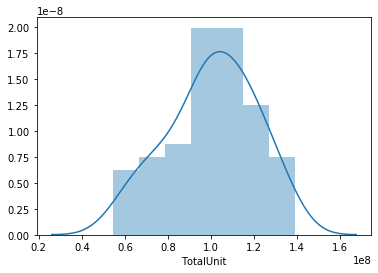

In [0]:
#Daily sales distribution of Istanbu
sns.distplot(sales_data.groupby(sales_data.index).TotalUnit.sum())

### Test Train Split for Exploratory Analysis

In [0]:
train_start,train_end = "2015-01-31","2018-12-31"
test_start,test_end = "2019-01-31","2019-06-30"
sales_data_train = sales_data[train_start:train_end]
sales_data_test = sales_data[test_start:test_end]

print('Number of months in training set:', sales_data_train.index.nunique())
print('Number of months in test set:', sales_data_test.index.nunique())

Number of months in training set: 48
Number of months in test set: 6


## İstanbul

### Sales Graph

In [0]:
exp_single = ExploratorySingle(sales_data)

exp_single.set_target_column('TotalUnit')
exp_single.filter_groupby(il = 'İstanbul')

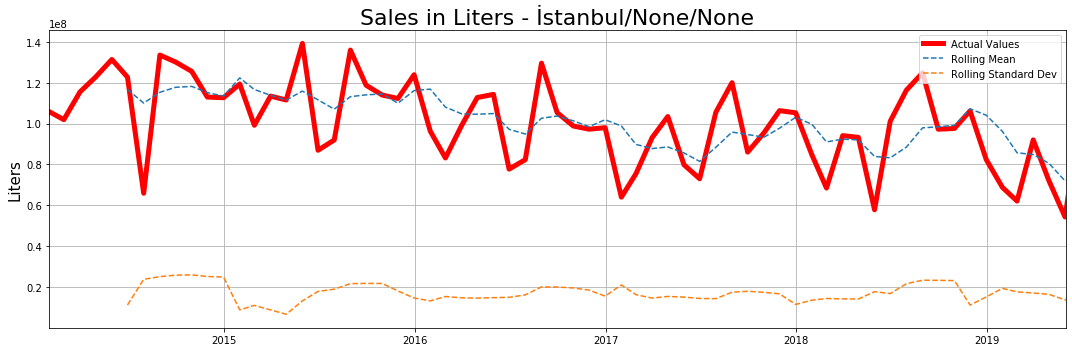

In [0]:
exp_single.sales_graph()

### Monthly Boxplots

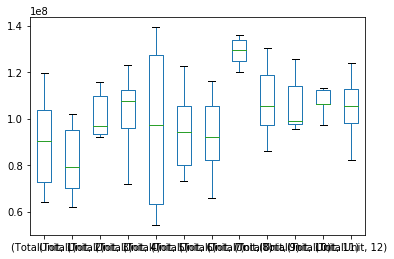

In [0]:
exp_single.monthly_boxplot()

### Seasonal Decompose

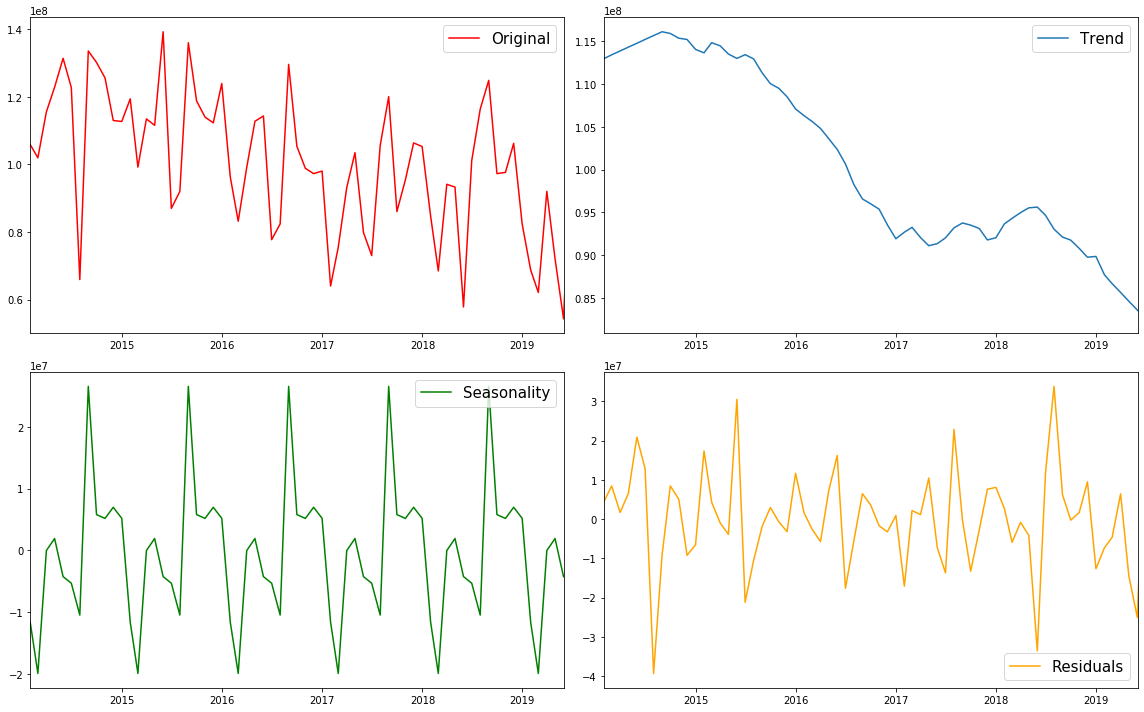

In [0]:
#Seasonal Decompose of Sales Data
trend_1, seasonal_1, residual_1 = exp_single.sd_fn()

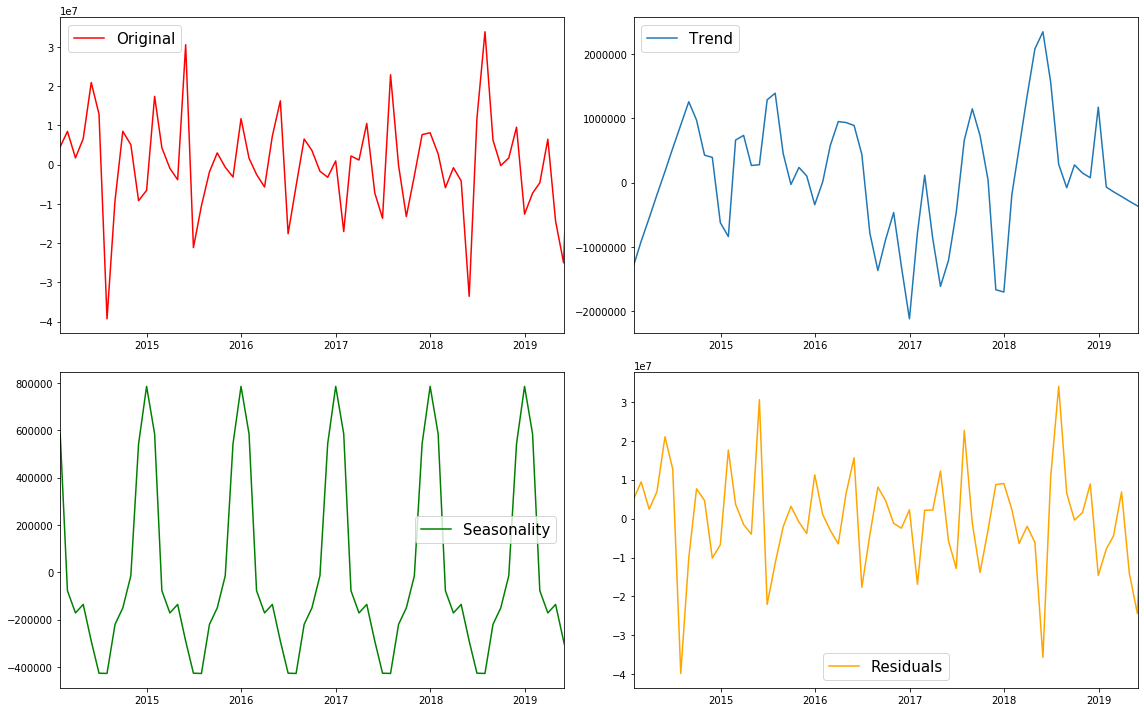

In [0]:
#Seasonal Decompose of Residuals of Sales Data
trend_2, seasonal_2, residual_2 = exp_single.sd_fn_resid()

### ADF Test

In [0]:
#ADF Test with original series for Stationarity
exp_single.adf_fn()

Original Serie
ADF Statistic: -0.980499
p-value: 0.760310
Critical Values:
	1%: -3.558
	5%: -2.917
	10%: -2.596


In [0]:
#ADF Test with first difference of the original series for Stationarity
exp_single.adf_fn(difference=1)

Difference - 1
ADF Statistic: -3.666761
p-value: 0.004606
Critical Values:
	1%: -3.560
	5%: -2.918
	10%: -2.597


### ACF and PACF Graphs

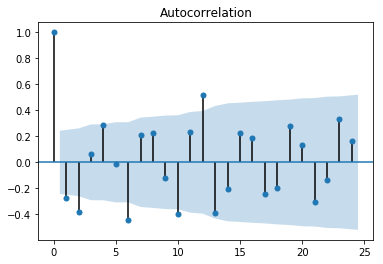

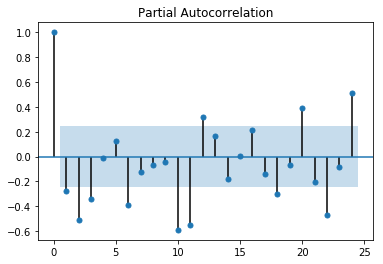

In [0]:
exp_single.acf_pacf_plots(lag=24, alfa=0.05, difference = 1)

### Monthly Variation

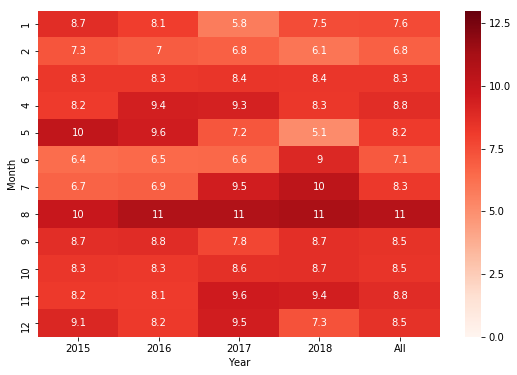

In [0]:
#Monthly Percentage Sales 
exp_single.monthly_variation()

## Districts

### District vs Year Table

In [0]:
#Yearly Sales by Districts
pd.pivot_table(data=sales_data_train,index = "District",columns = "Year", values = "TotalUnit", 
               aggfunc="sum", margins = True).sort_values(by = "All", ascending = False)

Year                      2015  ...              All
District                        ...                 
All           1,367,117,284.20  ... 4,794,413,592.54
Kadıköy         122,902,672.63  ...   474,717,730.61
Beyoğlu         134,155,700.40  ...   401,532,654.98
Fatih            97,470,580.69  ...   307,438,465.28
Şişli            63,480,534.00  ...   209,808,307.69
Beşiktaş         54,402,367.32  ...   199,075,575.08
Bahçelievler     46,466,082.83  ...   164,225,123.32
Küçükçekmece     49,446,519.38  ...   161,872,789.33
Kağıthane        44,628,668.06  ...   160,053,455.76
Gaziosmanpaşa    42,603,157.35  ...   157,684,918.02
Kartal           43,511,499.55  ...   155,671,564.21
Bakırköy         39,135,996.28  ...   150,293,605.01
Ataşehir         35,349,200.90  ...   140,117,214.19
Pendik           38,391,523.74  ...   139,245,823.94
Maltepe          38,349,576.14  ...   138,487,123.75
Sarıyer          37,403,629.56  ...   136,691,838.65
Ümraniye         34,946,429.53  ...   133,442,691.99
Bağcılar         38,939,542.59  ...   130,964,844.05
Eyüp             34,091,332.12  ...   122,955,450.76
Bayrampaşa       31,617,893.35  ...   112,105,281.94
Üsküdar          33,931,790.46  ...   108,660,070.05
Esenyurt         25,377,989.94  ...   102,275,073.68
Sultangazi       29,539,017.17  ...   101,919,454.41
Zeytinburnu      25,674,287.62  ...    92,006,099.24
Esenler          26,845,295.56  ...    91,394,861.52
Büyükçekmece     21,864,343.33  ...    76,628,886.75
Beykoz           23,528,897.91  ...    74,854,589.10
Güngören         19,987,804.55  ...    69,559,893.01
Silivri          21,183,218.10  ...    68,824,221.65
Beylikdüzü       18,211,868.53  ...    66,108,570.88
Tuzla            17,731,797.97  ...    64,320,128.34
Sancaktepe       16,826,745.27  ...    63,795,706.26
Başakşehir       13,873,750.80  ...    49,141,088.10
Çatalca          13,019,888.94  ...    43,839,958.89
Arnavutköy        9,573,623.15  ...    41,278,812.49
Çekmeköy         10,615,611.21  ...    41,173,777.45
Sultanbeyli       6,131,034.32  ...    21,800,815.04
Adalar            5,907,412.94  ...    20,447,127.12

[38 rows x 5 columns]

### Sales Graphs

In [0]:
exp_mult = ExploratoryMultiple(sales_data_train)
exp_mult.set_target_column('TotalUnit')
exp_mult.set_iteration_column('District')
exp_mult.dataframe_filter()

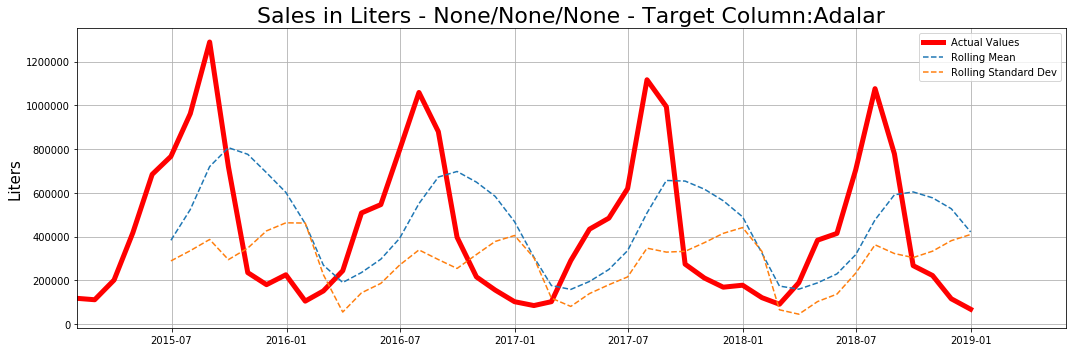

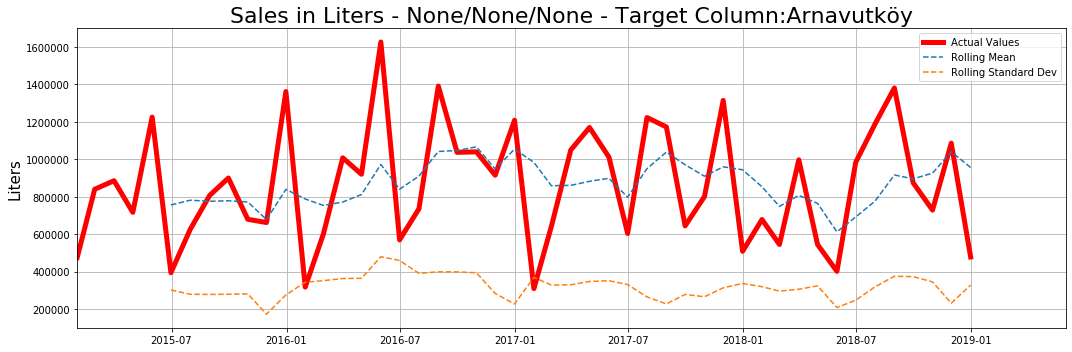

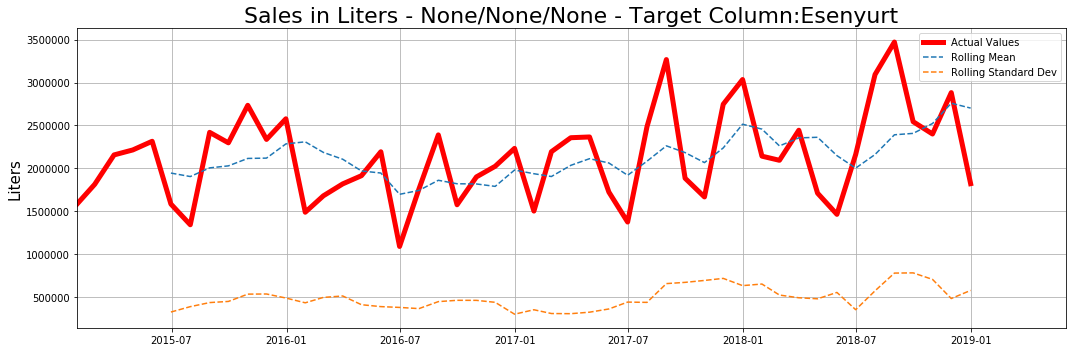

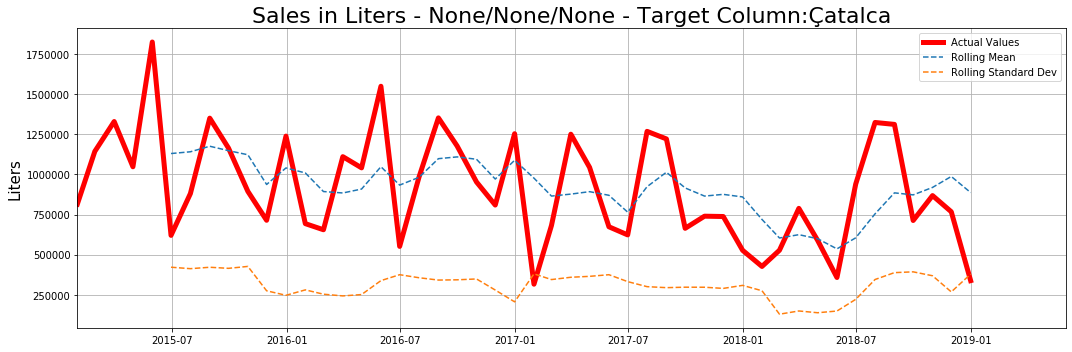

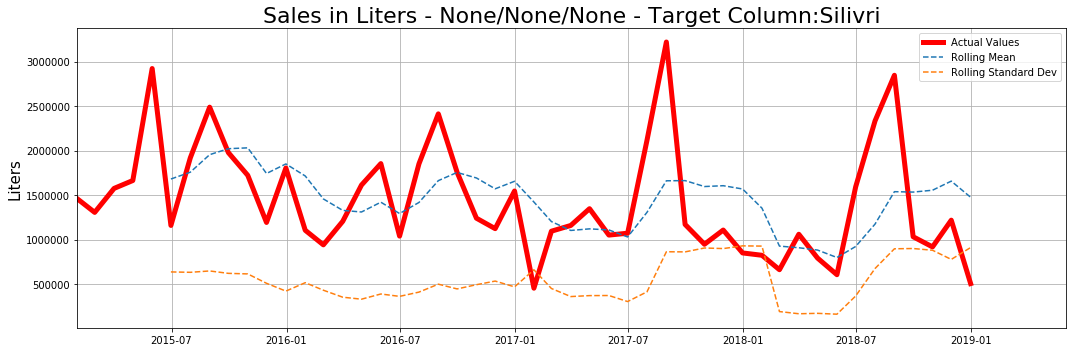

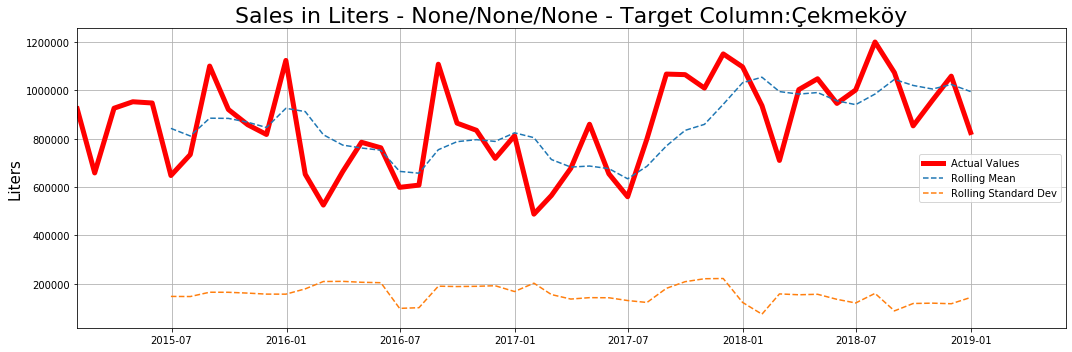

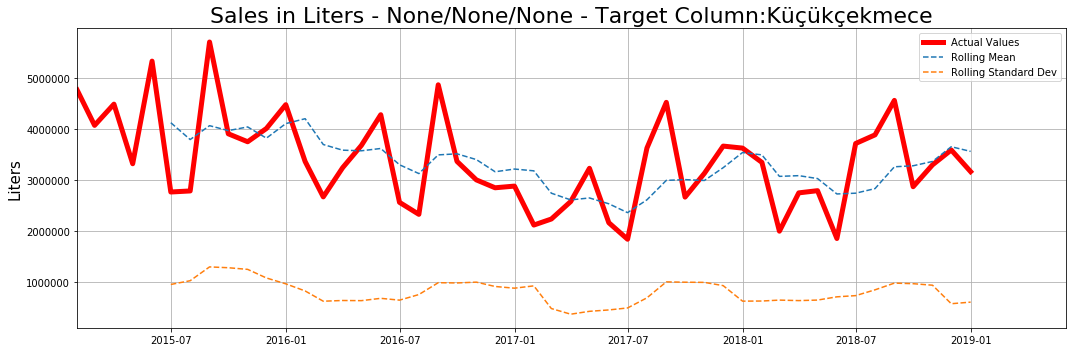

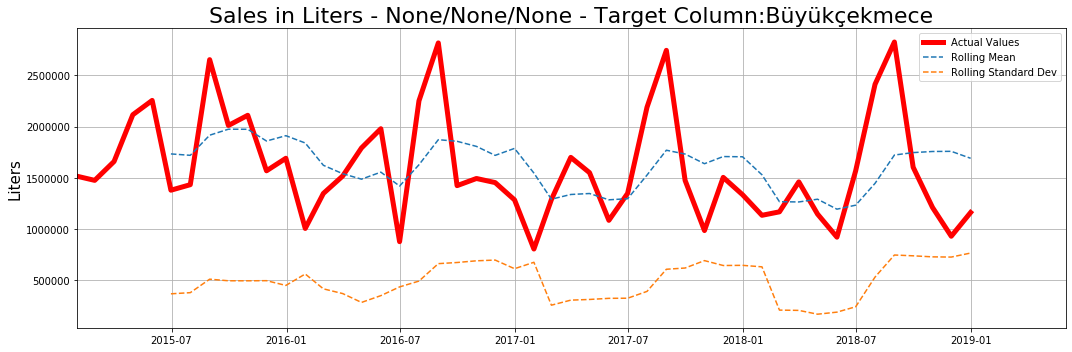

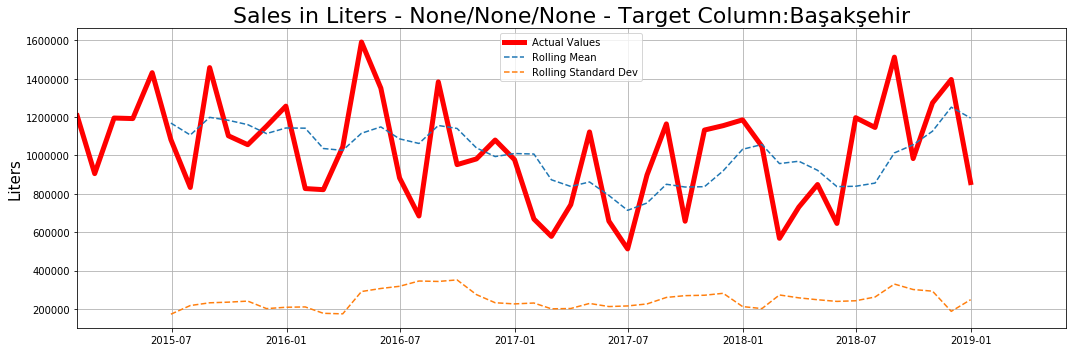

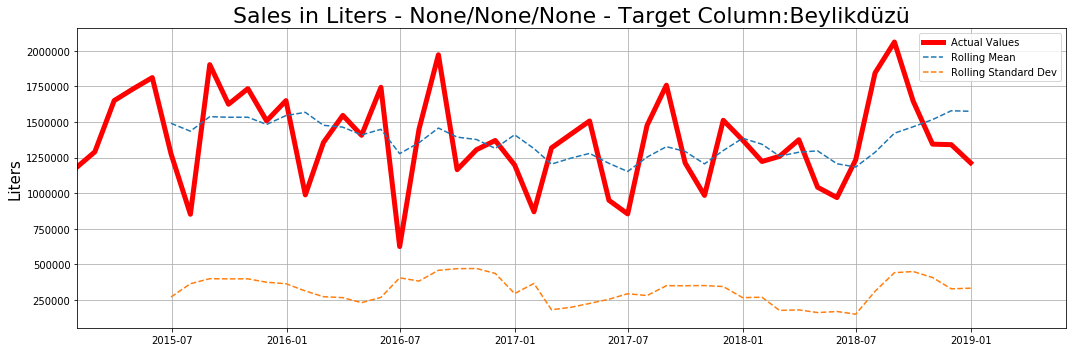

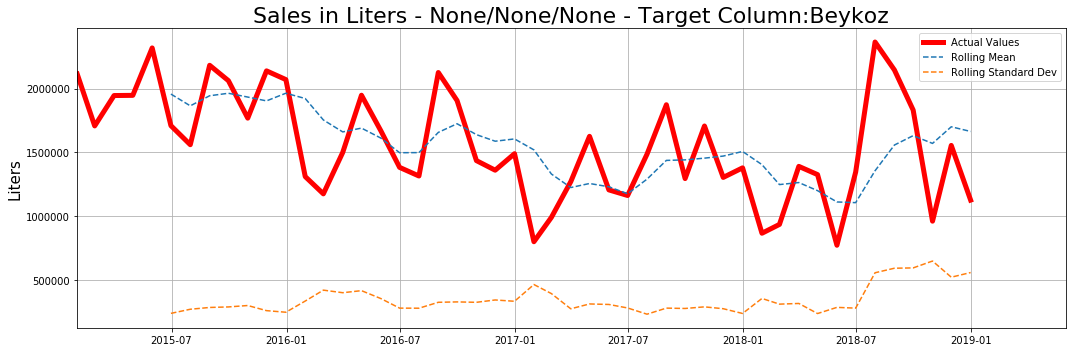

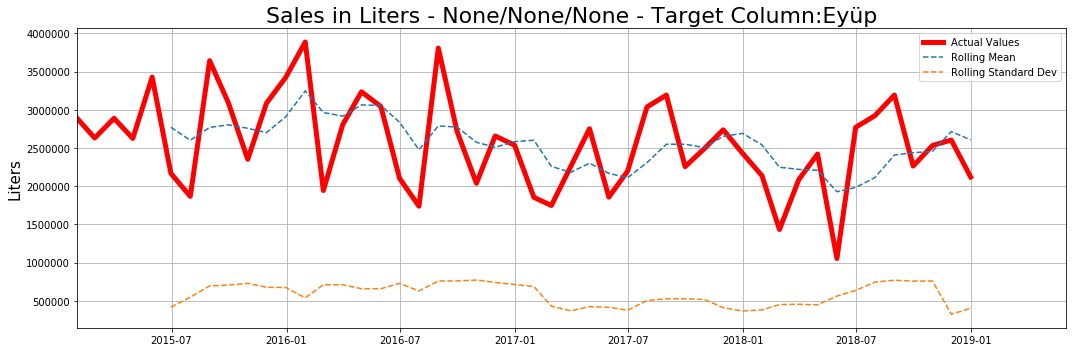

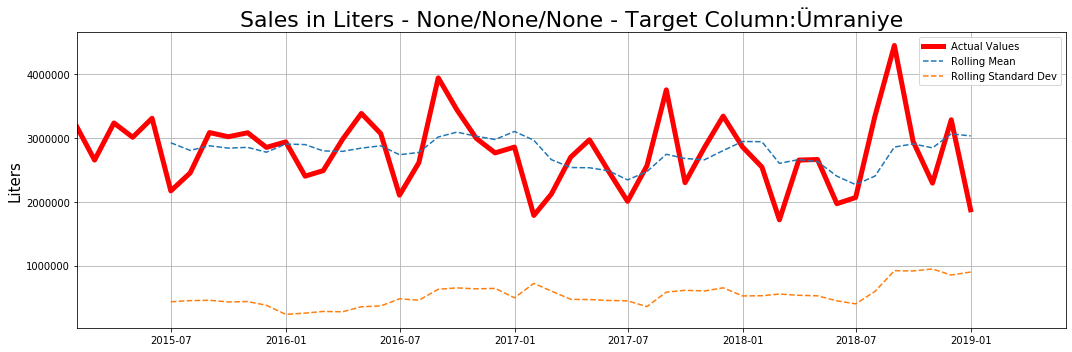

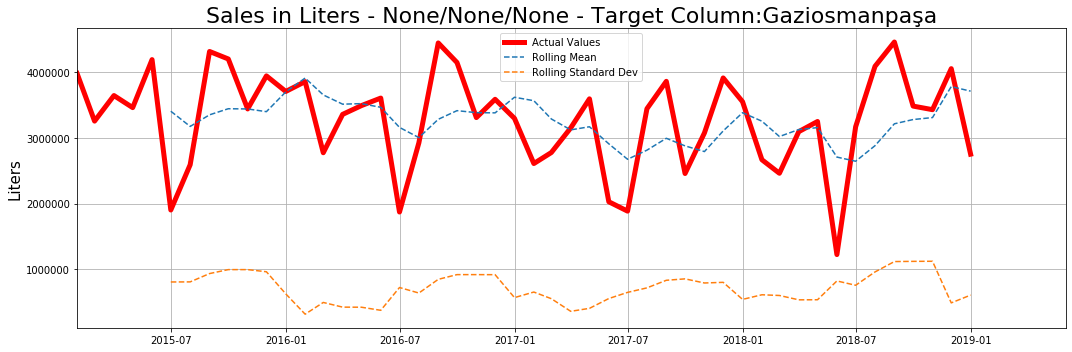

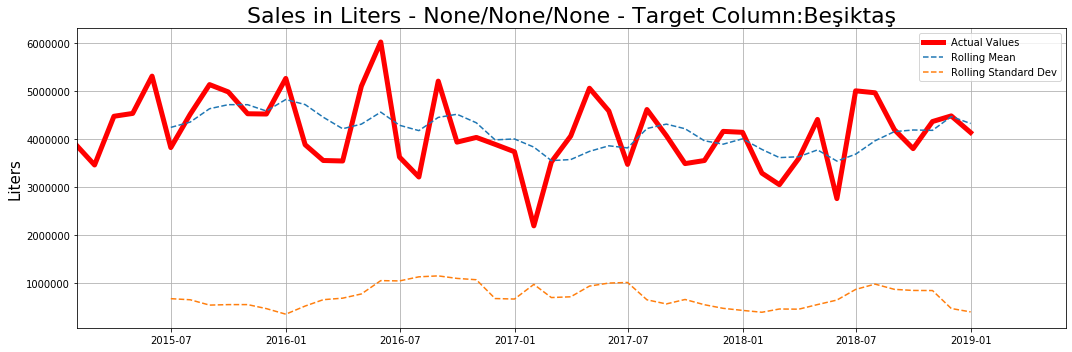

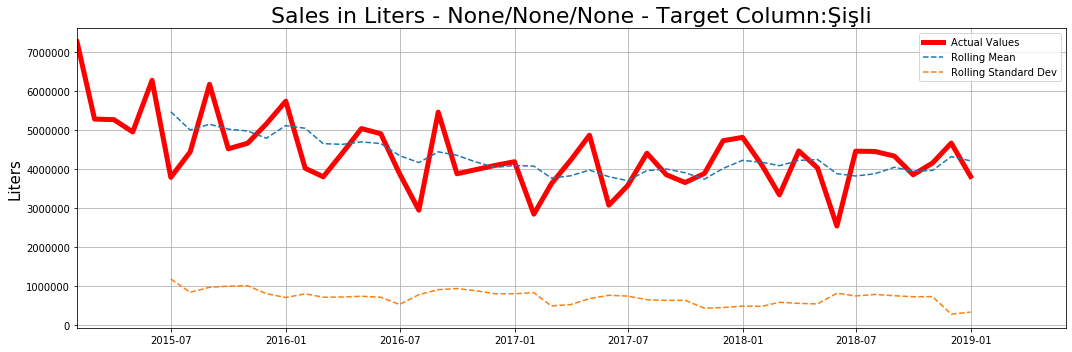

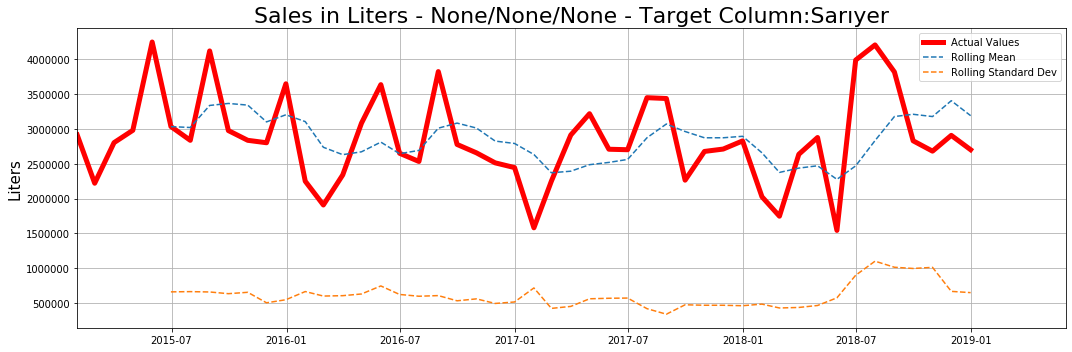

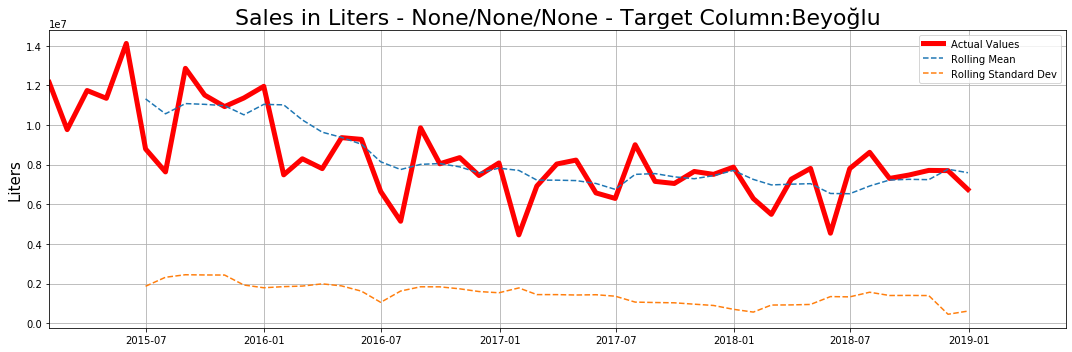

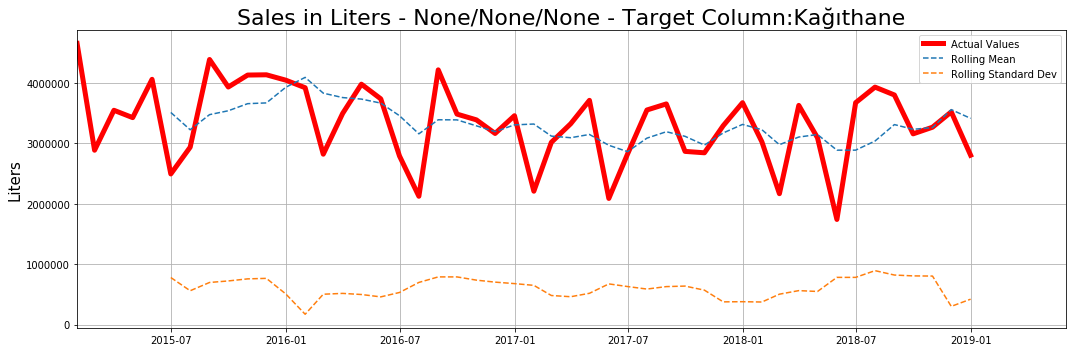

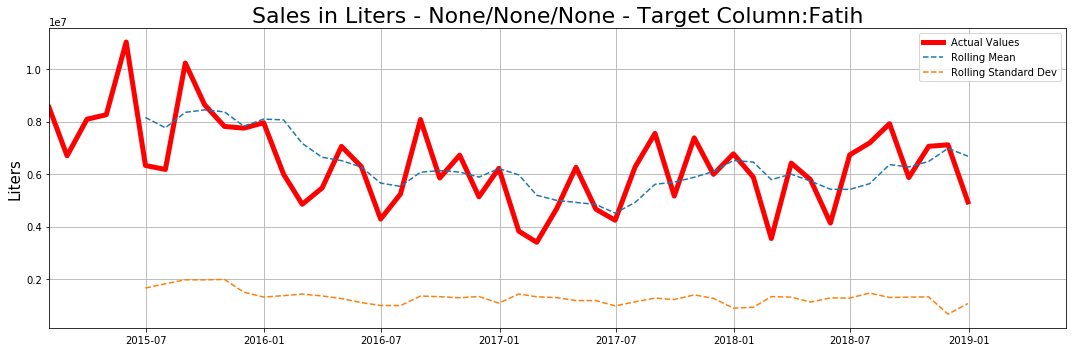

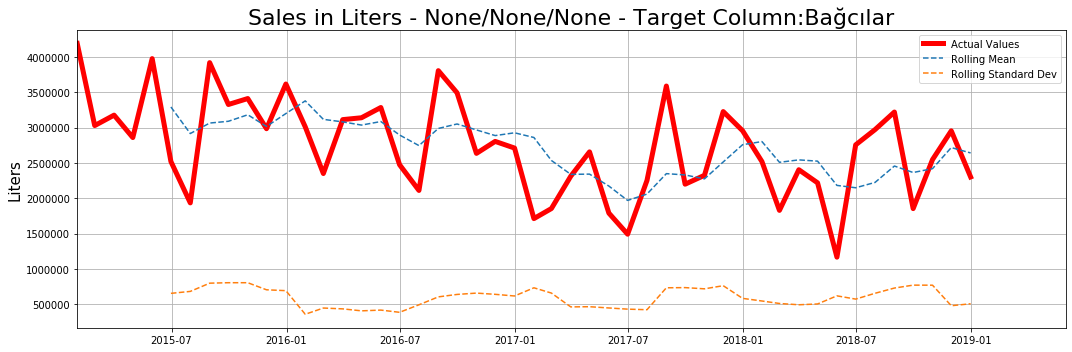

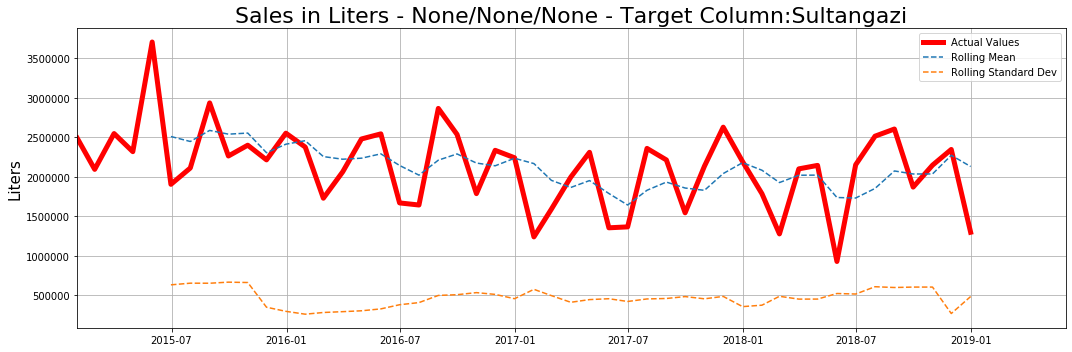

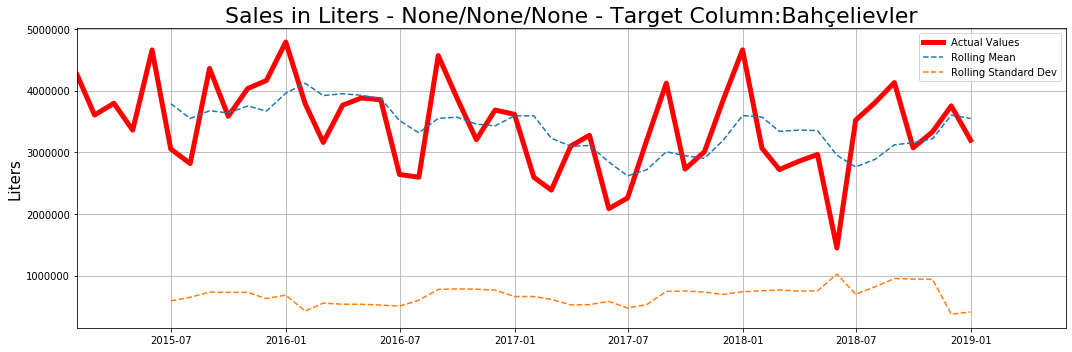

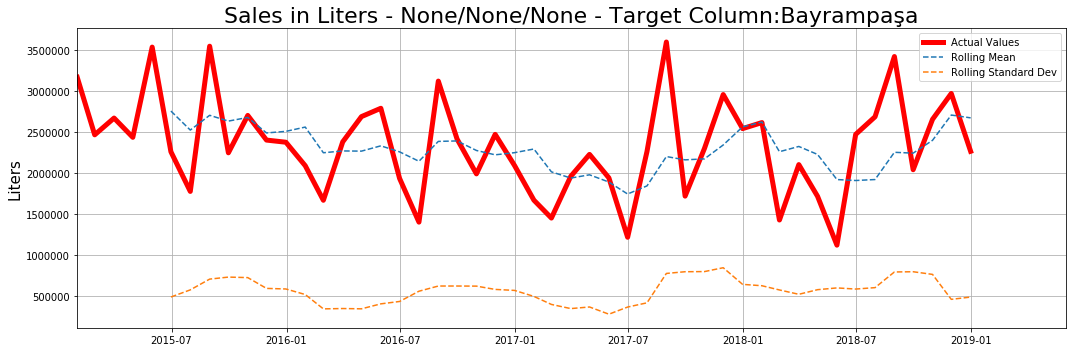

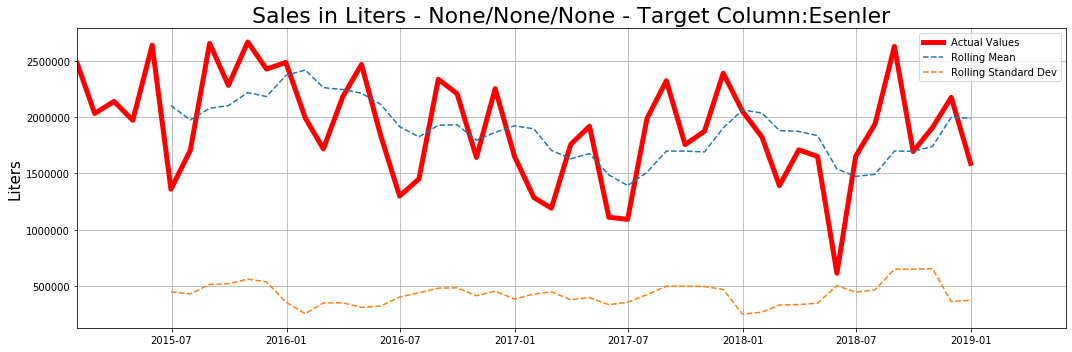

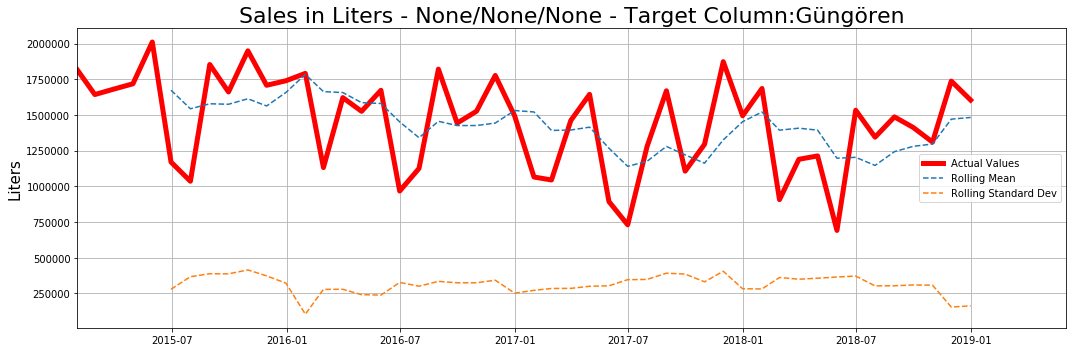

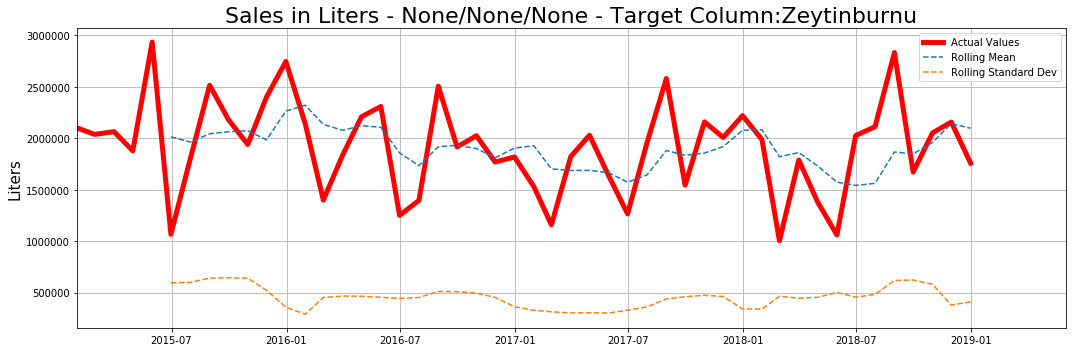

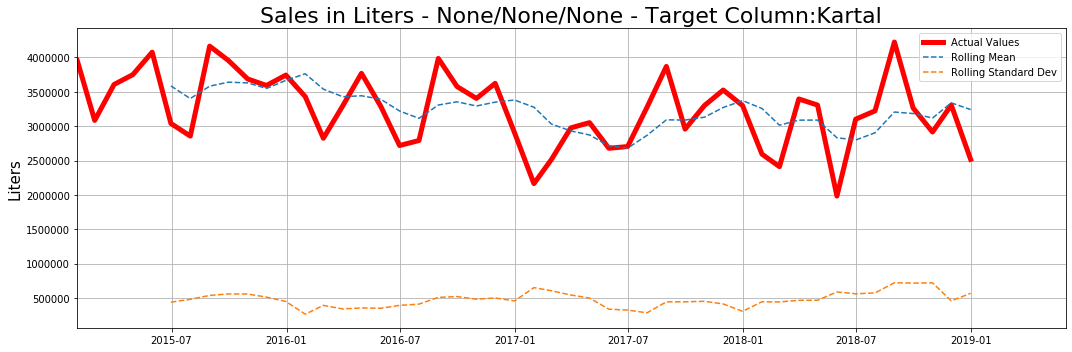

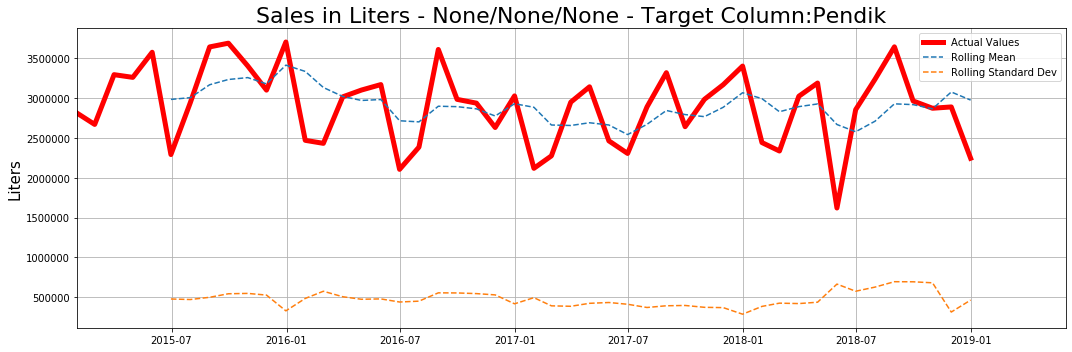

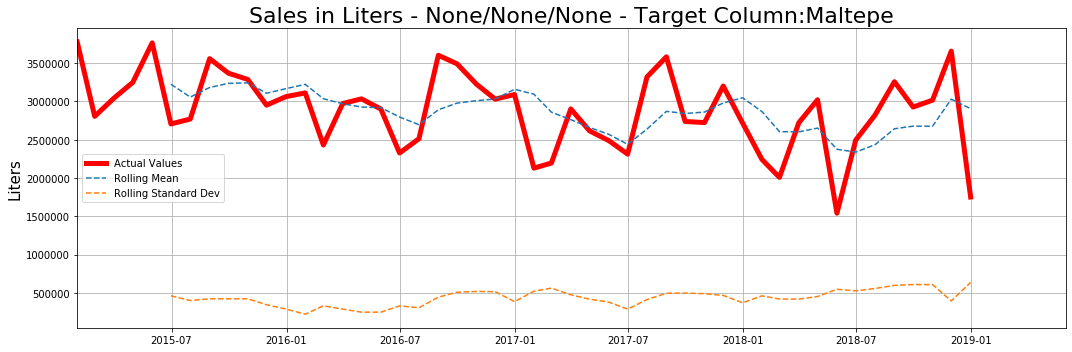

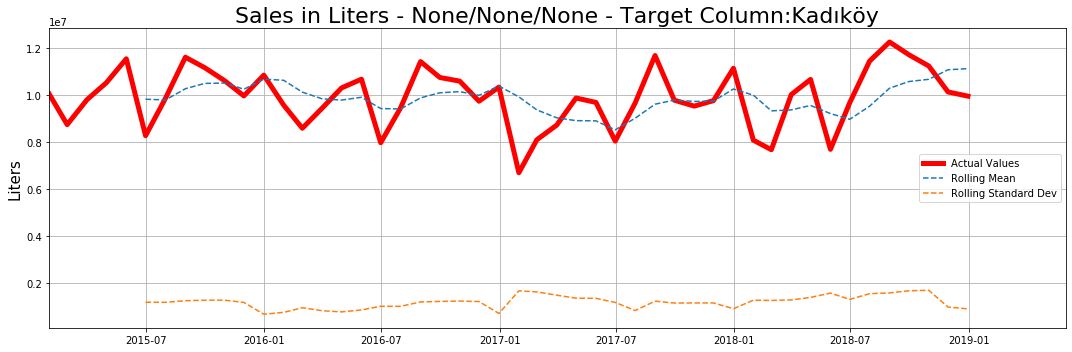

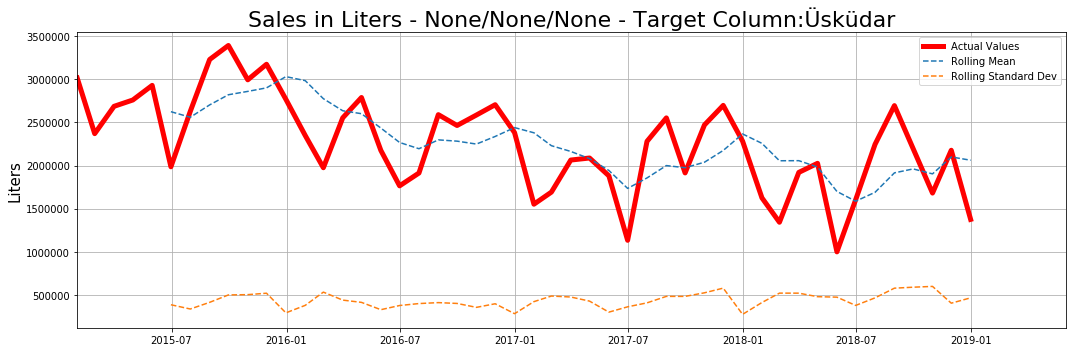

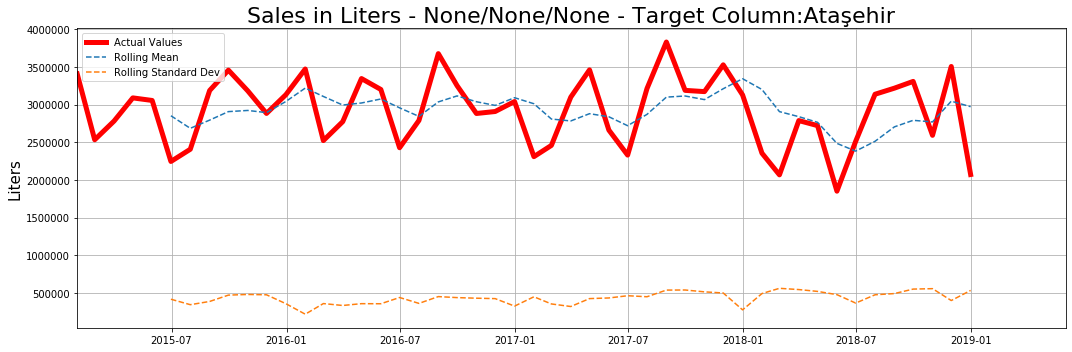

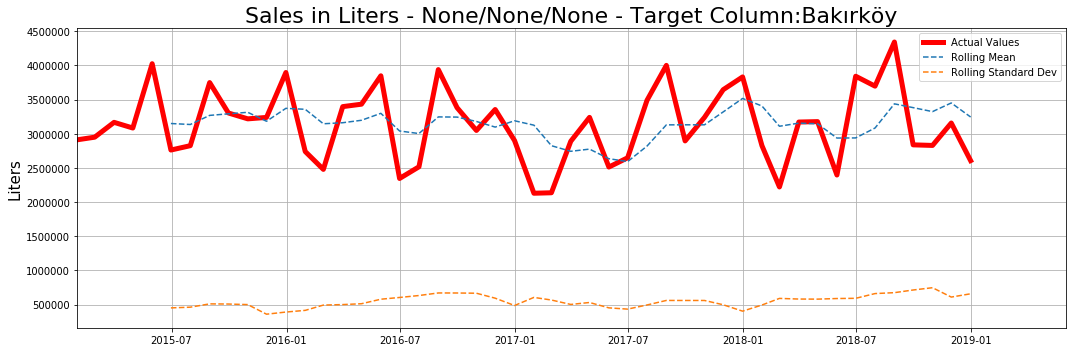

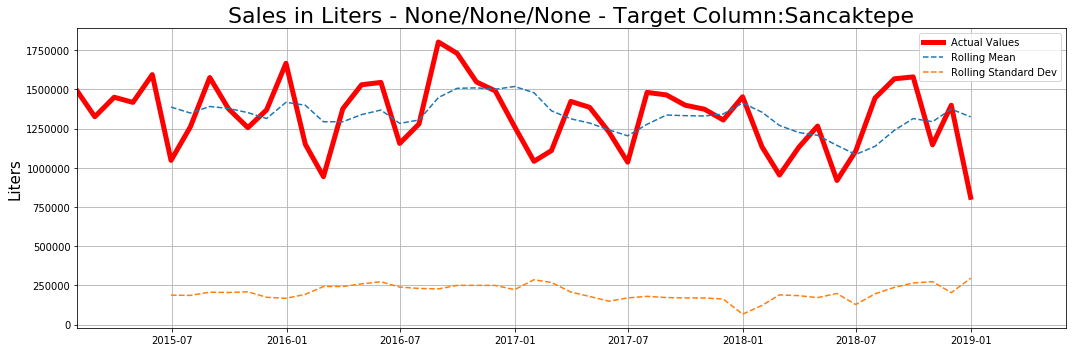

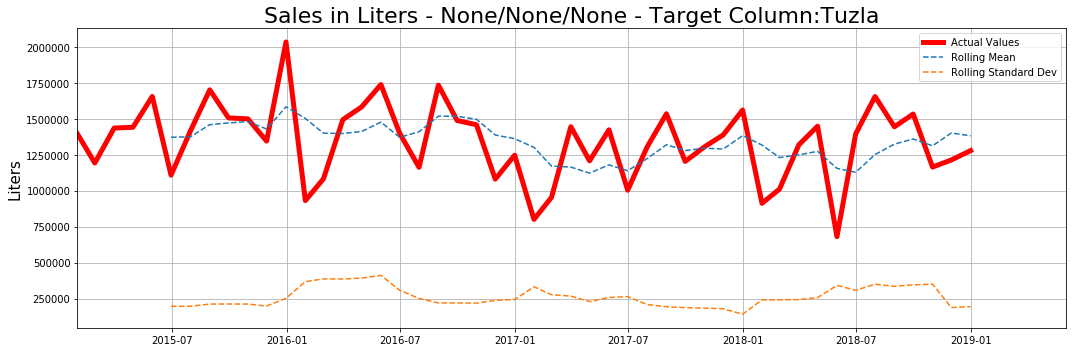

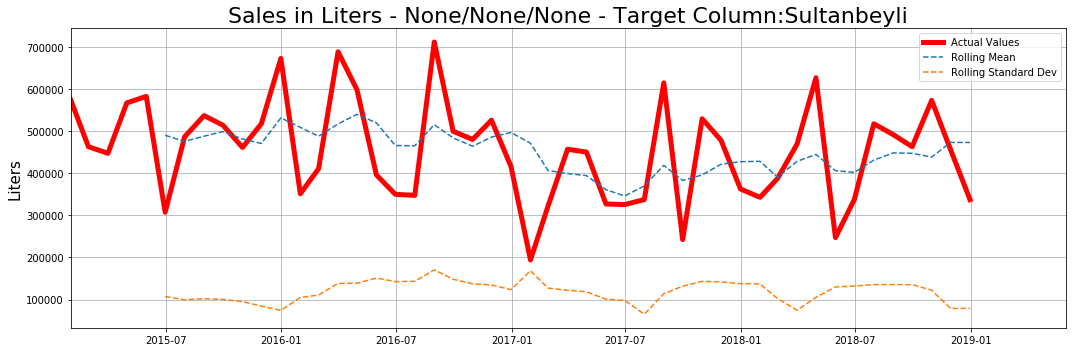

In [0]:
#Sales Graphs for Each Districts
exp_mult.all_sales_graphs()

### Monthly Boxplots

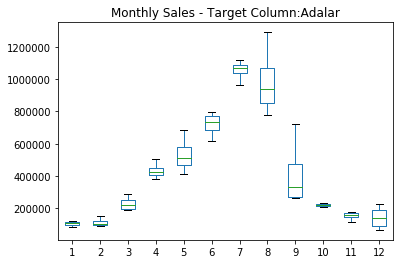

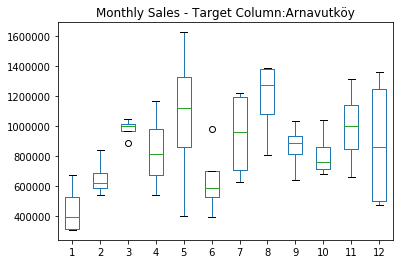

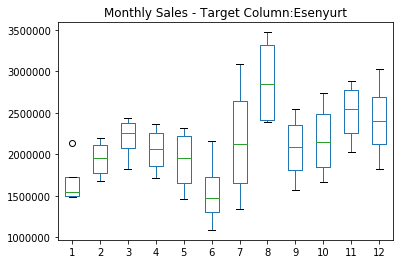

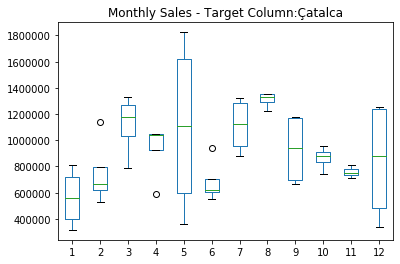

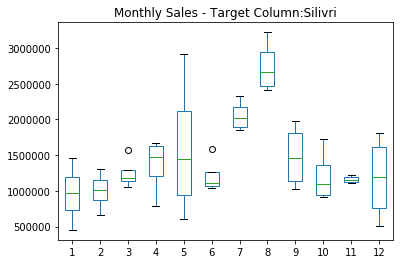

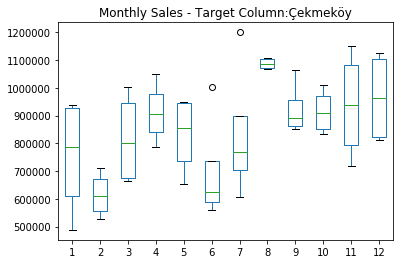

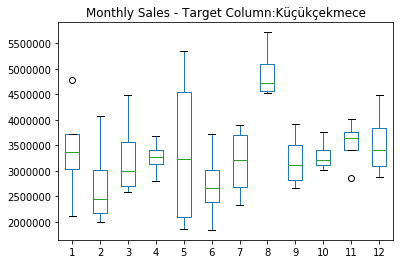

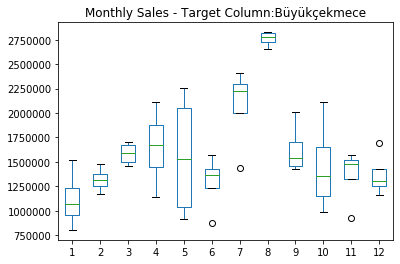

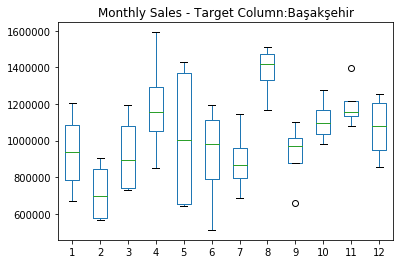

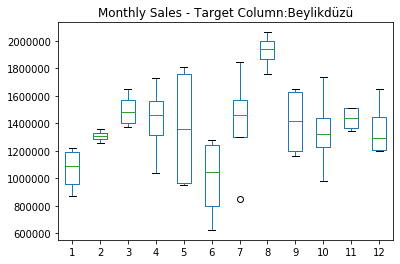

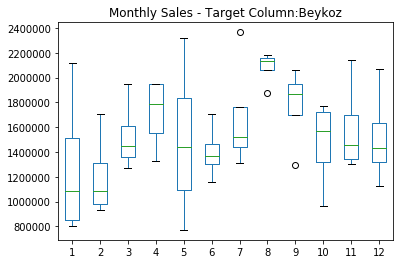

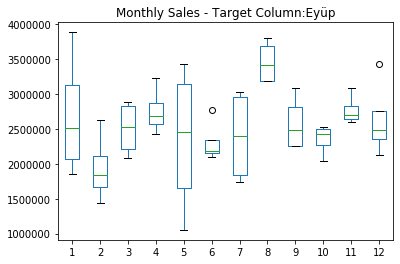

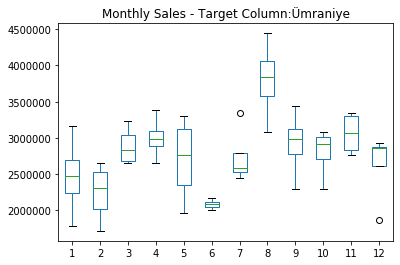

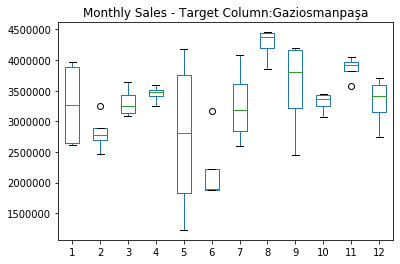

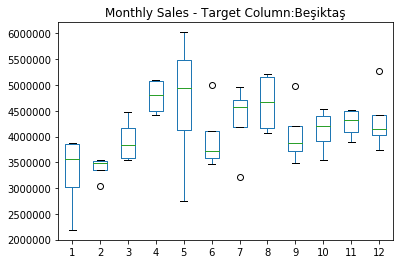

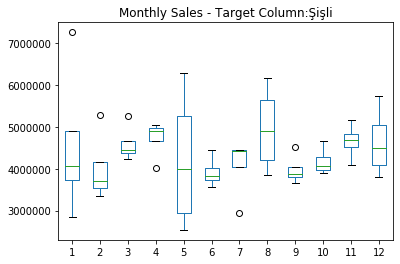

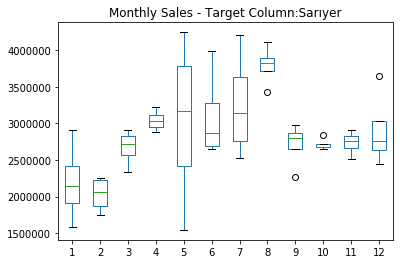

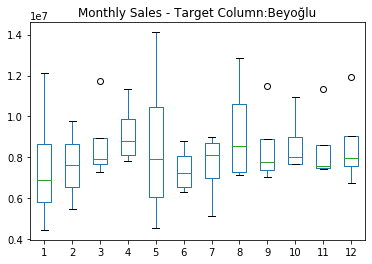

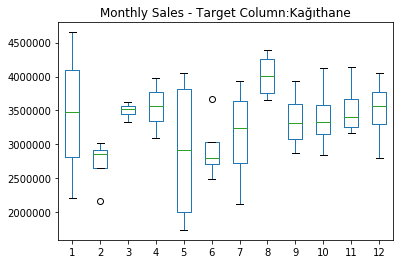

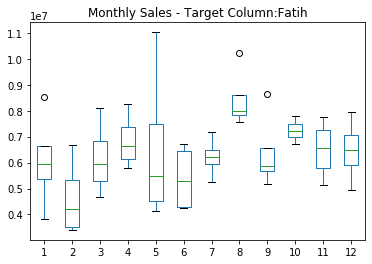

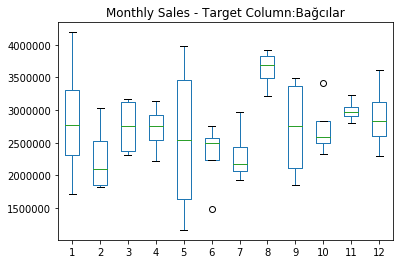

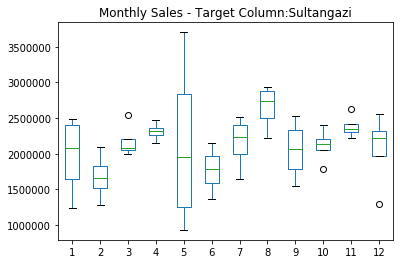

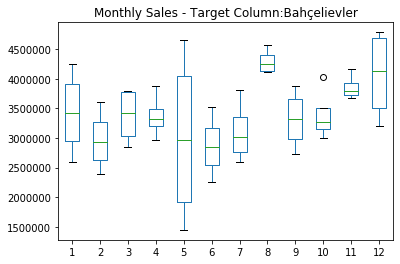

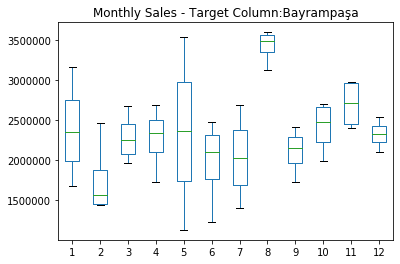

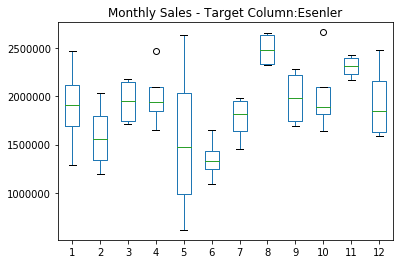

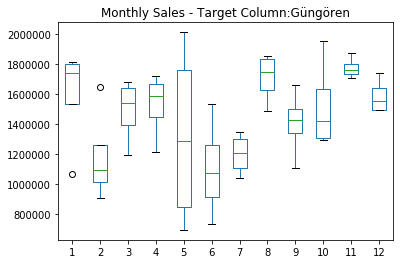

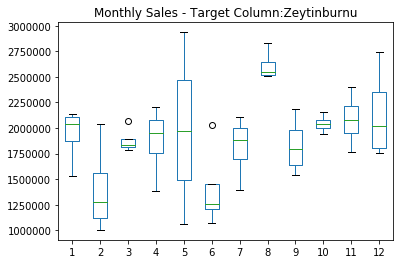

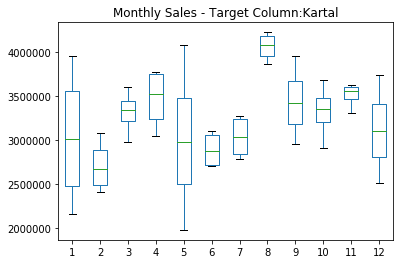

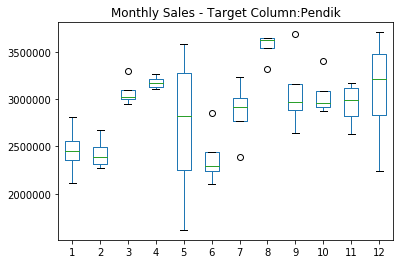

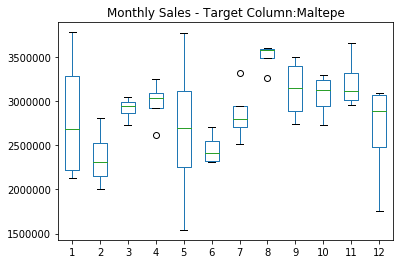

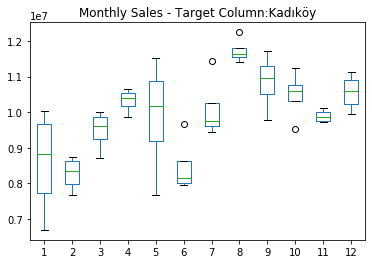

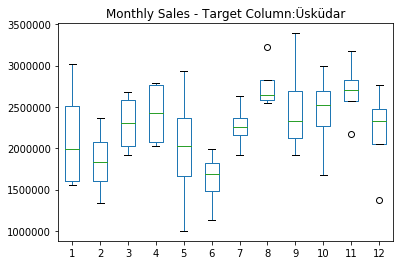

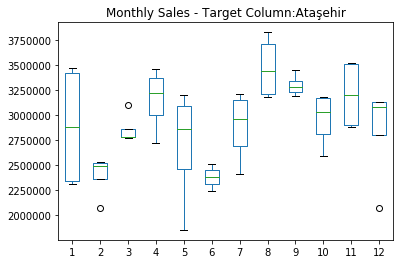

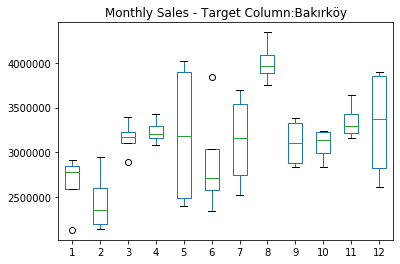

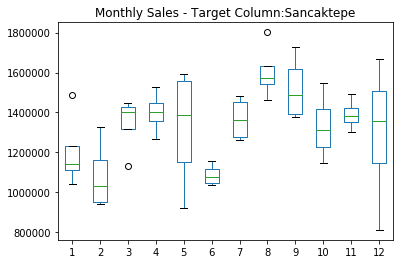

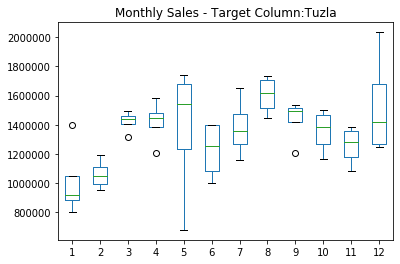

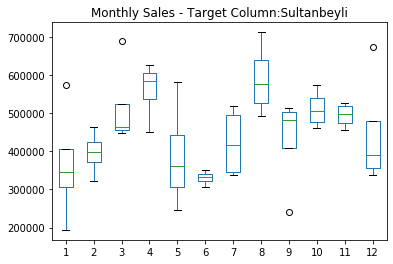

In [0]:
exp_mult.all_monthly_boxplots()

### Monthly Variations

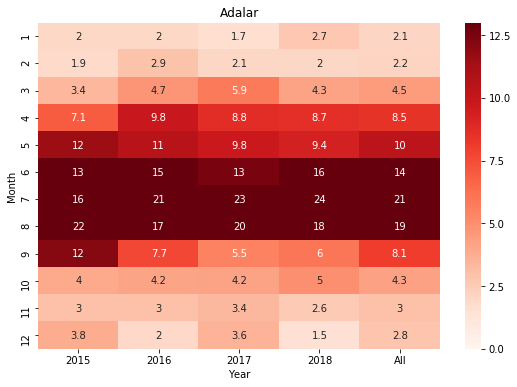

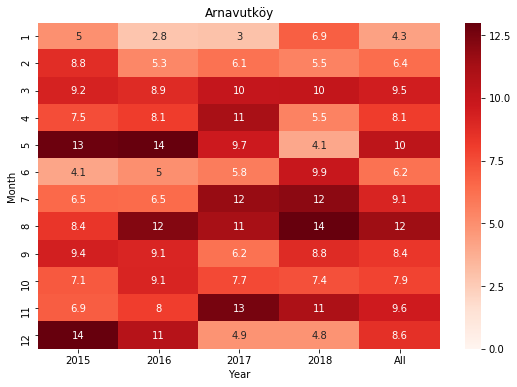

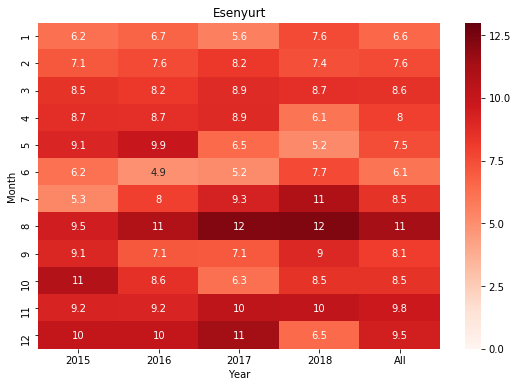

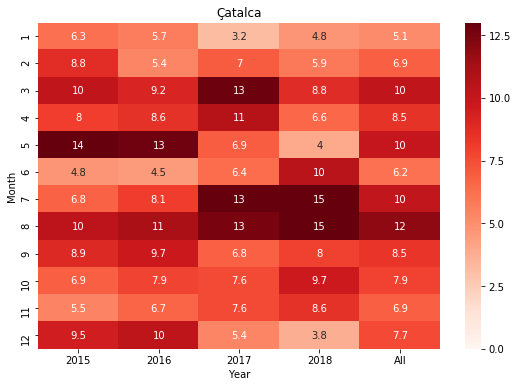

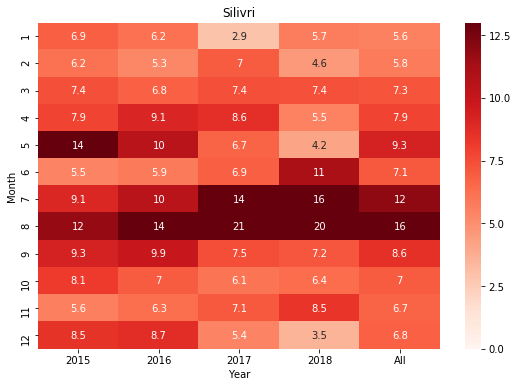

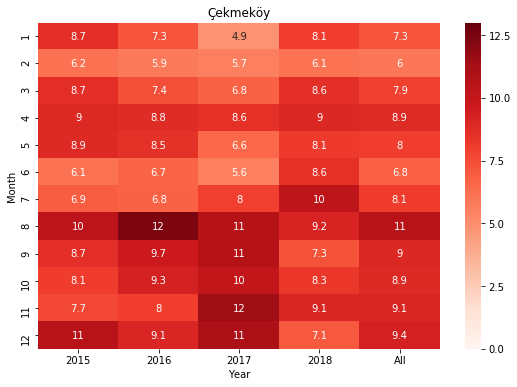

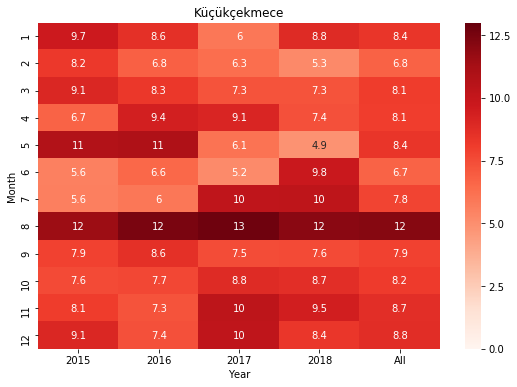

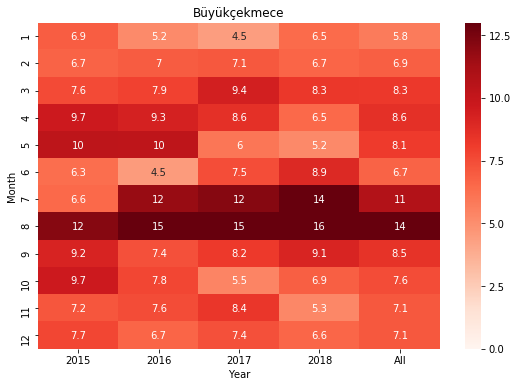

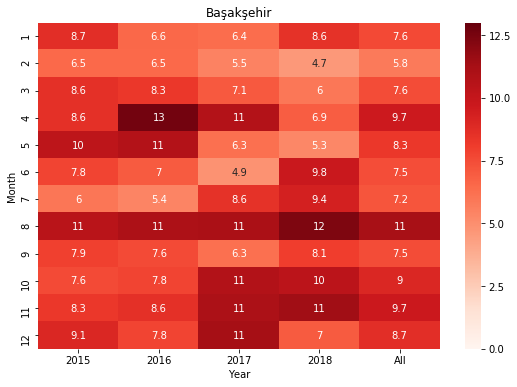

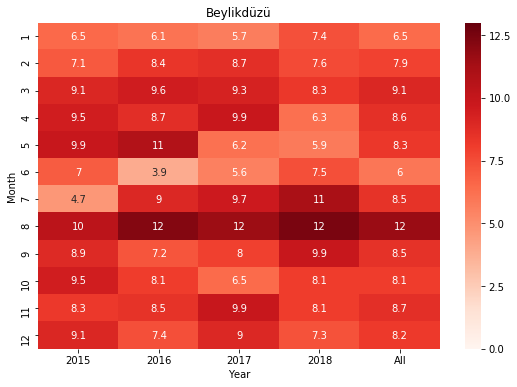

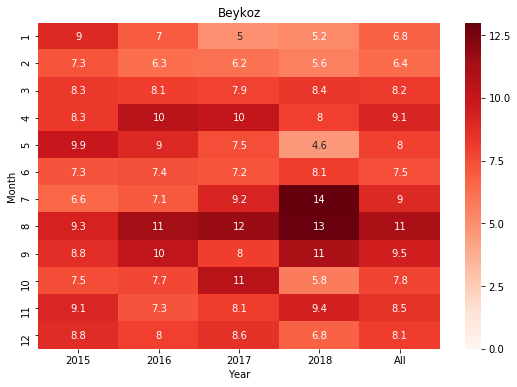

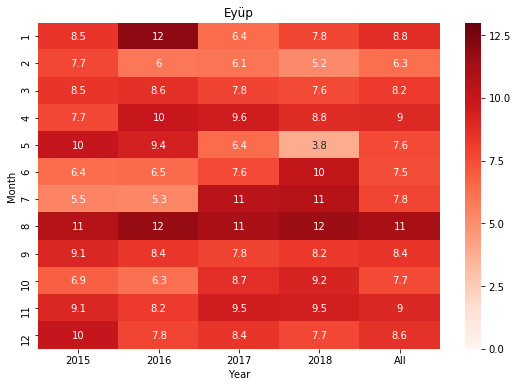

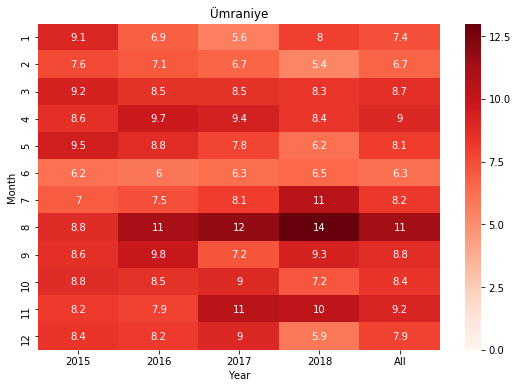

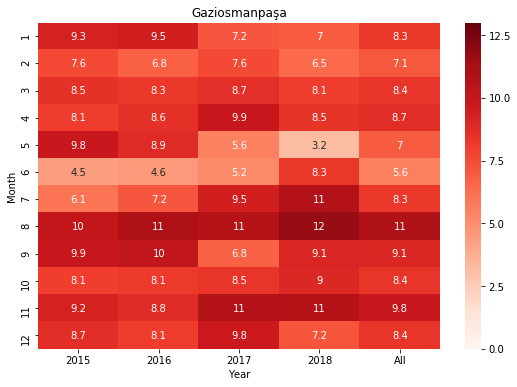

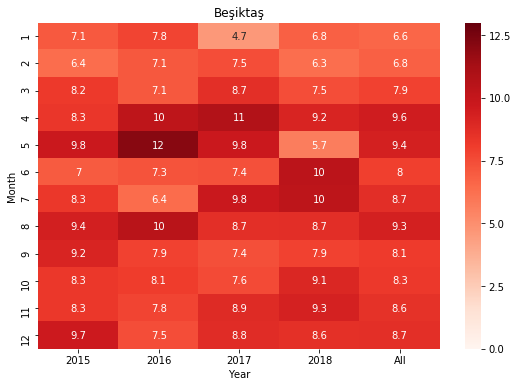

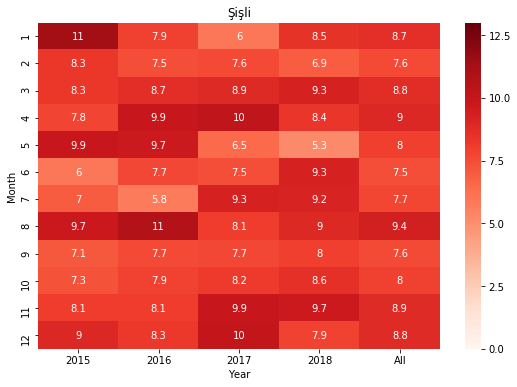

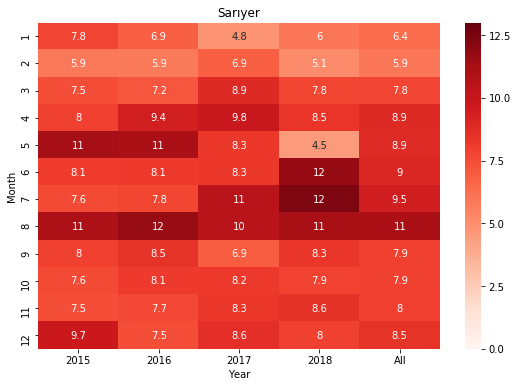

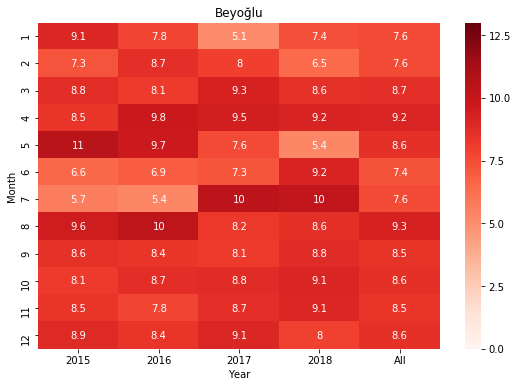

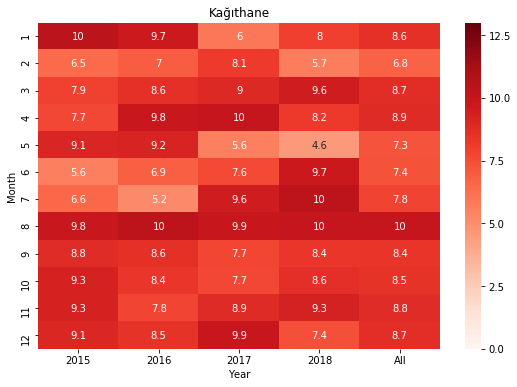

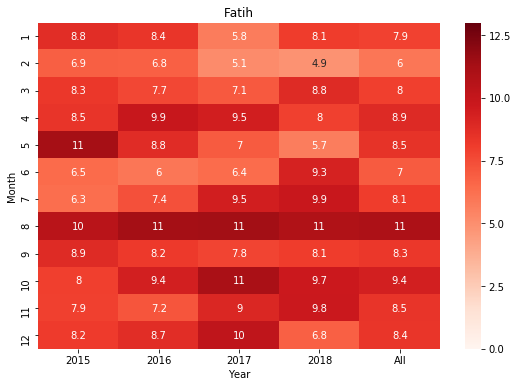

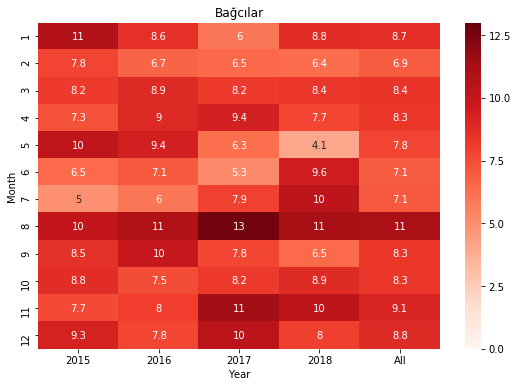

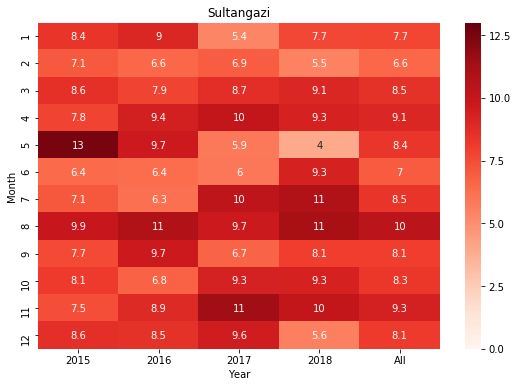

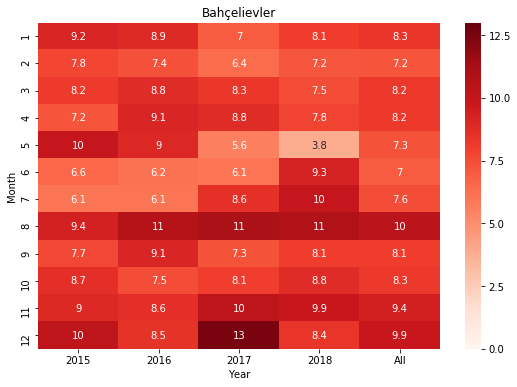

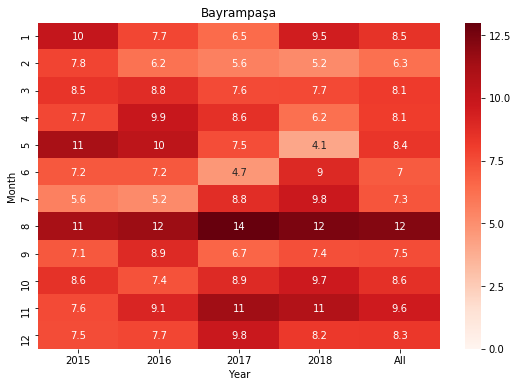

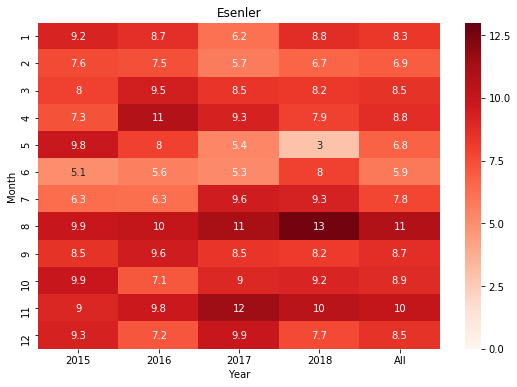

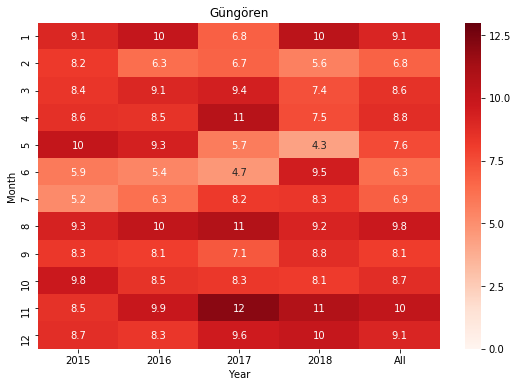

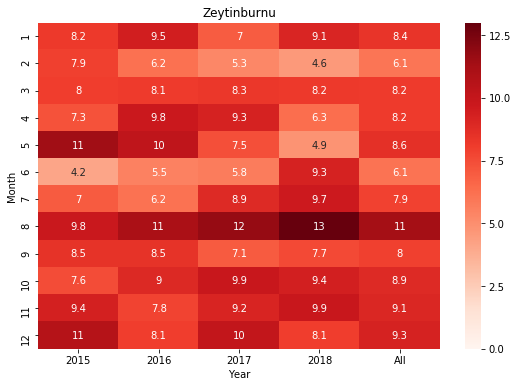

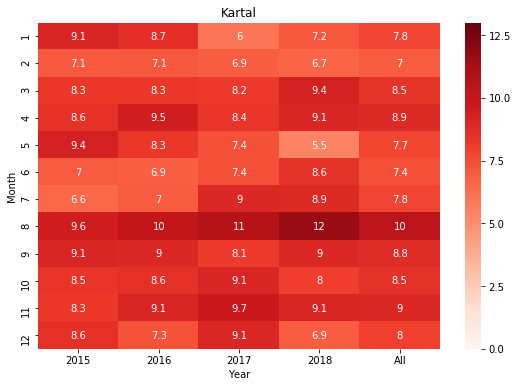

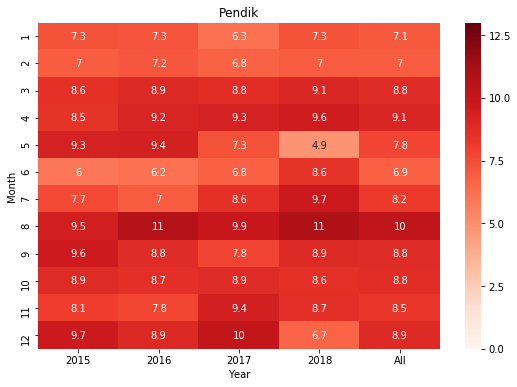

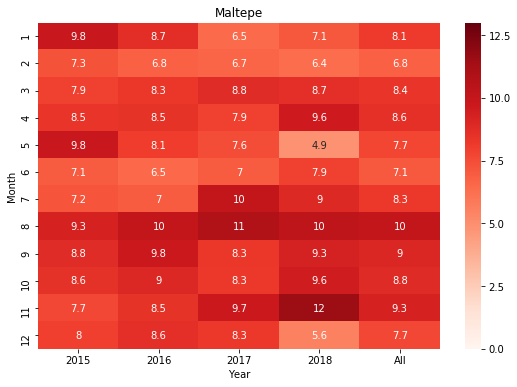

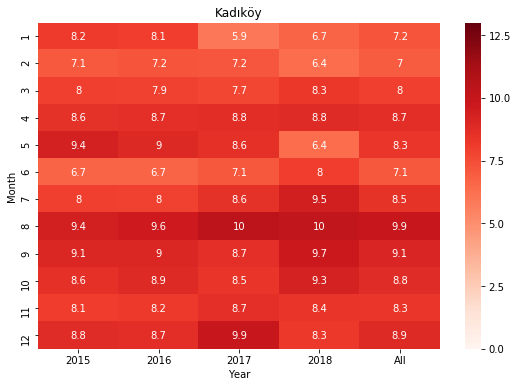

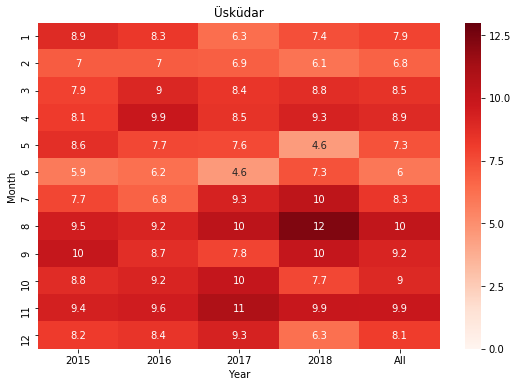

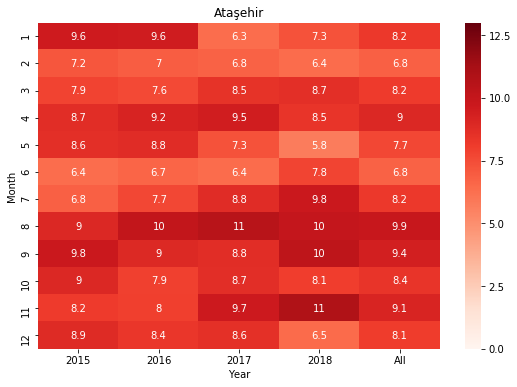

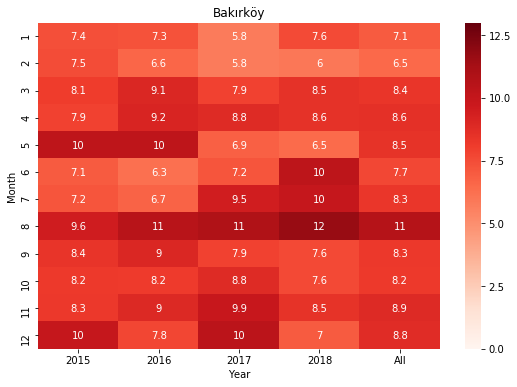

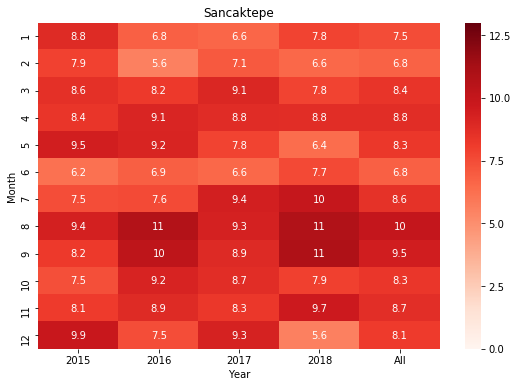

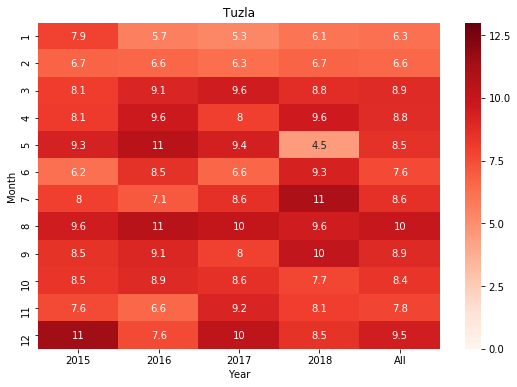

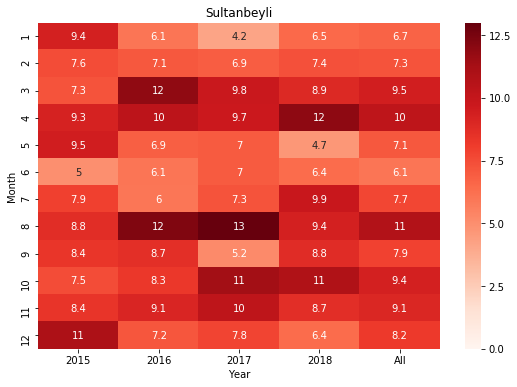

In [0]:
exp_mult.all_monthly_variation()

### ADF Test Results

In [0]:
#ADF Test results of all districts and total number of districts between thresholds (1%, 5%, 10%).
exp_mult.all_adf_summary(difference = 1)

ADF Test Results Summary:
Total number of targets: 37
Number of targets with p-value smaller than 5%: 37
Number of targets with ADF Statistic smaller than 1%: 36
Number of targets with ADF Statistic between 1% - 5%: 1
Number of targets with ADF Statistic between 5% - 10%: 0
Number of targets with ADF Statistic larger than 10%: 0


İlçe  ADF Statistic  p-value    1%    5%   10%
0          Adalar          -7.61     0.00 -3.63 -2.95 -2.61
1      Arnavutköy          -4.37     0.00 -3.63 -2.95 -2.61
2        Esenyurt          -3.93     0.00 -3.63 -2.95 -2.61
3         Çatalca          -7.54     0.00 -3.63 -2.95 -2.61
4         Silivri         -11.80     0.00 -3.63 -2.95 -2.61
5        Çekmeköy          -4.26     0.00 -3.60 -2.94 -2.61
6    Küçükçekmece          -7.31     0.00 -3.59 -2.93 -2.60
7    Büyükçekmece          -8.76     0.00 -3.63 -2.95 -2.61
8      Başakşehir          -3.72     0.00 -3.63 -2.95 -2.61
9      Beylikdüzü          -4.11     0.00 -3.63 -2.95 -2.61
10         Beykoz          -6.07     0.00 -3.62 -2.94 -2.61
11           Eyüp          -4.71     0.00 -3.61 -2.94 -2.61
12       Ümraniye          -5.56     0.00 -3.63 -2.95 -2.61
13  Gaziosmanpaşa          -5.26     0.00 -3.63 -2.95 -2.61
14       Beşiktaş          -7.30     0.00 -3.59 -2.93 -2.60
15          Şişli          -9.85     0.00 -3.59 -2.93 -2.60
16        Sarıyer          -5.90     0.00 -3.63 -2.95 -2.61
17        Beyoğlu          -7.62     0.00 -3.59 -2.93 -2.60
18      Kağıthane          -8.67     0.00 -3.59 -2.93 -2.60
19          Fatih          -4.01     0.00 -3.63 -2.95 -2.61
20       Bağcılar          -4.26     0.00 -3.63 -2.95 -2.61
21     Sultangazi          -4.20     0.00 -3.61 -2.94 -2.61
22   Bahçelievler          -4.31     0.00 -3.63 -2.95 -2.61
23     Bayrampaşa          -4.66     0.00 -3.63 -2.95 -2.61
24        Esenler          -5.46     0.00 -3.62 -2.94 -2.61
25       Güngören          -4.11     0.00 -3.63 -2.95 -2.61
26    Zeytinburnu          -4.99     0.00 -3.63 -2.95 -2.61
27         Kartal          -5.02     0.00 -3.63 -2.95 -2.61
28         Pendik          -4.91     0.00 -3.63 -2.95 -2.61
29        Maltepe          -6.01     0.00 -3.62 -2.94 -2.61
30        Kadıköy          -5.85     0.00 -3.63 -2.95 -2.61
31        Üsküdar          -6.97     0.00 -3.62 -2.94 -2.61
32       Ataşehir          -4.24     0.00 -3.63 -2.95 -2.61
33       Bakırköy          -4.55     0.00 -3.63 -2.95 -2.61
34     Sancaktepe          -5.09     0.00 -3.62 -2.94 -2.61
35          Tuzla          -7.29     0.00 -3.59 -2.93 -2.60
36    Sultanbeyli          -3.26     0.02 -3.63 -2.95 -2.61

### ACF anf PACF Results

In [0]:
#Number of Districts Each Lag of Sales Data is significant in ACF.
significant_acf = exp_mult.acf_results(lag=24, alfa=0.05, difference = 1)

Total number of unique values in target column: 37
Number of Errors: 0
Number of times Lag - 1 is significant: 18
Number of times Lag - 2 is significant: 22
Number of times Lag - 3 is significant: 0
Number of times Lag - 4 is significant: 8
Number of times Lag - 5 is significant: 0
Number of times Lag - 6 is significant: 21
Number of times Lag - 7 is significant: 0
Number of times Lag - 8 is significant: 1
Number of times Lag - 9 is significant: 0
Number of times Lag - 10 is significant: 1
Number of times Lag - 11 is significant: 1
Number of times Lag - 12 is significant: 14
Number of times Lag - 13 is significant: 0
Number of times Lag - 14 is significant: 0
Number of times Lag - 15 is significant: 0
Number of times Lag - 16 is significant: 0
Number of times Lag - 17 is significant: 0
Number of times Lag - 18 is significant: 0
Number of times Lag - 19 is significant: 0
Number of times Lag - 20 is significant: 0
Number of times Lag - 21 is significant: 0
Number of times Lag - 22 is sig

In [0]:
significant_acf.head()

İlçe Significant Lags
0      Adalar      [1, 11, 12]
1  Arnavutköy           [1, 6]
2    Esenyurt          [2, 12]
3     Çatalca       [1, 6, 12]
4     Silivri          [6, 12]

In [0]:
#Number of Districts Each Lag of Sales Data is significant in PACF.
significant_pacf = exp_mult.pacf_results(lag=24, alfa=0.05, method='ols', difference = 1)

Total number of unique values in target column: 37
Number of Errors: 0
Number of times Lag - 1 is significant: 18
Number of times Lag - 2 is significant: 37
Number of times Lag - 3 is significant: 28
Number of times Lag - 4 is significant: 4
Number of times Lag - 5 is significant: 1
Number of times Lag - 6 is significant: 28
Number of times Lag - 7 is significant: 7
Number of times Lag - 8 is significant: 1
Number of times Lag - 9 is significant: 14
Number of times Lag - 10 is significant: 28
Number of times Lag - 11 is significant: 25
Number of times Lag - 12 is significant: 16
Number of times Lag - 13 is significant: 7
Number of times Lag - 14 is significant: 5
Number of times Lag - 15 is significant: 3
Number of times Lag - 16 is significant: 10
Number of times Lag - 17 is significant: 6
Number of times Lag - 18 is significant: 12
Number of times Lag - 19 is significant: 12
Number of times Lag - 20 is significant: 12
Number of times Lag - 21 is significant: 22
Number of times Lag - 

In [0]:
significant_pacf.head()

İlçe                                   Significant Lags
0      Adalar            [1, 2, 6, 7, 9, 10, 11, 20, 22, 23, 24]
1  Arnavutköy  [1, 2, 3, 4, 6, 11, 14, 18, 19, 22, 23, 24, 25...
2    Esenyurt             [2, 6, 10, 11, 12, 21, 22, 24, 26, 27]
3     Çatalca                   [1, 2, 3, 6, 10, 11, 22, 23, 24]
4     Silivri      [2, 6, 9, 10, 11, 16, 17, 20, 21, 22, 26, 27]

## Sample Entropy

In [0]:
TotalUnit_series = sales_data_train.groupby(sales_data_train.index).TotalUnit.sum()
SampEn(U=TotalUnit_series.values, m=2, r=0.2*np.std(TotalUnit_series.values))

2.70805020110221

In [0]:
for i in sales_data_train['District'].unique():
  TotalUnit_series = sales_data_train[sales_data_train['District'] == i].groupby(sales_data_train[sales_data_train['District'] == i].index).TotalUnit.sum()
  print(i,':',SampEn(U=TotalUnit_series.values, m=2, r=0.2*np.std(TotalUnit_series.values)))

Adalar : 0.8873031950009028
Arnavutköy : 1.7047480922384253
Esenyurt : 2.5649493574615367
Çatalca : 2.3025850929940455
Silivri : 1.9924301646902063
Çekmeköy : inf
Küçükçekmece : 1.6739764335716716
Büyükçekmece : 2.772588722239781
Başakşehir : inf
Beylikdüzü : 1.8718021769015913
Beykoz : 1.8718021769015913
Eyüp : 1.6094379124341003
Ümraniye : 2.3025850929940455
Gaziosmanpaşa : 2.4849066497880004
Beşiktaş : 2.0794415416798357
Şişli : 2.3978952727983707
Sarıyer : 3.044522437723423
Beyoğlu : 1.7635885922613588
Kağıthane : 2.5649493574615367
Fatih : inf
Bağcılar : inf
Sultangazi : 2.639057329615259
Bahçelievler : 1.9459101490553135
Bayrampaşa : 2.70805020110221
Esenler : inf
Güngören : 1.540445040947149
Zeytinburnu : inf
Kartal : inf
Pendik : 2.3025850929940455
Maltepe : 1.8718021769015913
Kadıköy : 2.5649493574615367
Üsküdar : 1.1526795099383855
Ataşehir : 1.3862943611198906
Bakırköy : 2.4849066497880004
Sancaktepe : 2.70805020110221
Tuzla : 1.9459101490553135
Sultanbeyli : 2.1972245773362

# Exogeneous Variables

In [0]:
groupby_dict = {'TotalUnit':'sum',
                'GrossRevenue':'sum',
                'Discount':'sum',
                'NetRevenue':'sum'}

unit_df = sales_data.groupby('MonthBegin').agg(groupby_dict)

In [0]:
unit_df.head()

TotalUnit  GrossRevenue     Discount    NetRevenue
MonthBegin                                                        
2014-01-31 105,880,798.18 56,892,968.98   640,867.38 56,252,101.60
2014-02-28 101,957,734.32 55,649,613.20   602,656.59 55,046,956.61
2014-03-31 115,553,118.66 63,055,722.52   756,921.74 62,298,800.78
2014-04-30 122,855,704.64 67,322,064.48   845,591.96 66,476,472.52
2014-05-31 131,428,575.12 72,309,046.11 1,112,338.35 71,196,707.76

### Monthly Discount Percentage

In [0]:
unit_df['discount_perc'] = unit_df['Discount'] / unit_df['GrossRevenue']

### Price

In [0]:
unit_df['price'] = unit_df['GrossRevenue'] / unit_df['TotalUnit']

### Ramadan

In [0]:
ramazan = pd.read_excel(path+"ramazan.xlsx")

In [0]:
ramazan['ds'] = ramazan['ds'] + pd.offsets.MonthEnd()
ramazan.columns = ['MonthBegin', 'ramadan']
ramazan = pd.DataFrame(ramazan.groupby('MonthBegin').ramadan.sum(), columns=['ramadan'])
ramazan.head()

ramadan
MonthBegin         
2014-01-31        0
2014-02-28        0
2014-03-31        0
2014-04-30        0
2014-05-31        0

In [0]:
unit_df = unit_df.join(ramazan)

### Holidays

In [0]:
holiday = pd.read_excel(path+"holidays.xlsx")
holiday['MonthBegin'] = holiday['ds'] + pd.offsets.MonthEnd()

In [0]:
holiday.head()

ds    descr     type  duration MonthBegin
0 2014-01-01  YILBASI  YILBASI      1.00 2014-01-31
1 2014-04-23    RESMI    RESMI      1.00 2014-04-30
2 2014-05-01    RESMI    RESMI      1.00 2014-05-31
3 2014-05-19    RESMI    RESMI      1.00 2014-05-31
4 2014-07-27    AREFE     DINI      0.50 2014-07-31

In [0]:
#All holidays
holiday2 = pd.DataFrame(holiday.groupby('MonthBegin').duration.sum())
holiday2.columns = ['all_holiday']

In [0]:
unit_df = unit_df.join(holiday2).fillna(0)

In [0]:
#Religious
holiday3 = pd.DataFrame(holiday[holiday['type'] == 'DINI'].groupby('MonthBegin').duration.sum())
holiday3.columns = ['religious']

In [0]:
unit_df = unit_df.join(holiday3).fillna(0)

In [0]:
#Holiday without weekend
holiday['weekday_check'] = [1 if x < 5 else 0 for x in holiday['ds'].dt.dayofweek]

holiday4 = pd.DataFrame(holiday[holiday['weekday_check'] == 1].groupby('MonthBegin').duration.sum())
holiday4.columns = ['holiday_wo_weekend']

In [0]:
unit_df = unit_df.join(holiday4).fillna(0)

In [0]:
#Holiday with weekend
date_df = pd.DataFrame(pd.date_range('2014-01-01', '2019-12-31'), columns=['ds'])
date_df = date_df.merge(holiday[['ds','duration']], on='ds', how='left').fillna(0)
date_df['weekdend_check'] = [0 if x < 5 else 1 for x in date_df['ds'].dt.dayofweek]

In [0]:
holiday_w_weekend_list = []
for i in range(len(date_df['weekdend_check'].values)):
  if i == 0:
    holiday_w_weekend_list.append(date_df['duration'].values[i])
  else:
    holiday_w_weekend_list.append(date_df['weekdend_check'].values[i])
date_df['holiday_w_weekend'] = holiday_w_weekend_list
date_df['MonthBegin'] = date_df['ds'] + pd.offsets.MonthEnd()

holiday5 = pd.DataFrame(date_df.groupby('MonthBegin').holiday_w_weekend.sum())

In [0]:
unit_df = unit_df.join(holiday5).fillna(0)

In [0]:
unit_df.head(10)

TotalUnit  GrossRevenue  ...  holiday_wo_weekend  holiday_w_weekend
MonthBegin                               ...                                       
2014-01-31 105,880,798.18 56,892,968.98  ...                1.00               9.00
2014-02-28 101,957,734.32 55,649,613.20  ...                0.00               8.00
2014-03-31 115,553,118.66 63,055,722.52  ...                0.00              10.00
2014-04-30 122,855,704.64 67,322,064.48  ...                1.00               8.00
2014-05-31 131,428,575.12 72,309,046.11  ...                2.00               8.00
2014-06-30 122,764,540.06 67,583,159.78  ...                0.00              10.00
2014-07-31  65,918,909.59 37,633,126.10  ...                3.00               8.00
2014-08-31 133,588,009.12 76,982,941.98  ...                0.00               9.00
2014-09-30 130,199,303.84 75,525,301.65  ...                0.00               9.00
2014-10-31 125,611,298.28 73,218,979.17  ...                3.50               8.00

[10 rows x 11 columns]

### Newyear

In [0]:
unit_df['newyear'] = [1 if i == 12 else 0 for i in unit_df.index.month]

### Consumer Confidence Index, Tourist Numbers, Food Index and Temperature

In [0]:
cci = pd.read_excel(path+"cci.xlsx")
cci["MonthBegin"] = pd.to_datetime(cci["ds"])
cci.set_index("MonthBegin",inplace = True)
cci.index.freq="MS"
cci.index = cci.index  + pd.offsets.MonthEnd()

tourist = pd.read_excel(path+"touristwest.xlsx")
tourist["MonthBegin"] = pd.to_datetime(tourist["ds"])
tourist.set_index("MonthBegin",inplace = True)
tourist.index.freq="MS"
tourist.index = tourist.index  + pd.offsets.MonthEnd()
                    
food=pd.read_excel(path+"food_entert.xlsx")
food = food[["ds","food_usd"]]
food.columns = ["MonthBegin","food_usd"]
food.set_index("MonthBegin",inplace=True)
food.index.freq="MS"
food.index = pd.to_datetime(food.index)
food.index = food.index  + pd.offsets.MonthEnd()

isttemp = pd.read_excel(path+"ist_temp.xlsx")
isttemp["MonthBegin"] = pd.to_datetime(isttemp["D"])
isttemp.set_index("MonthBegin",inplace = True)
isttemp = isttemp.resample(rule="MS").mean()
isttemp.index = isttemp.index  + pd.offsets.MonthEnd()
isttemp.columns = ['temp']

In [0]:
unit_df = unit_df.join(cci)
unit_df = unit_df.join(tourist[['tourist']])
unit_df = unit_df.join(food)
unit_df = unit_df.join(isttemp)

In [0]:
unit_df.drop('ds', axis=1, inplace=True)

In [0]:
unit_df.head()

TotalUnit  GrossRevenue     Discount  ...  tourist  food_usd  temp
MonthBegin                                            ...                         
2014-01-31 105,880,798.18 56,892,968.98   640,867.38  ...   890528  5,326.06  9.09
2014-02-28 101,957,734.32 55,649,613.20   602,656.59  ...   847796  5,454.50  9.00
2014-03-31 115,553,118.66 63,055,722.52   756,921.74  ...  1184570  5,527.79 10.92
2014-04-30 122,855,704.64 67,322,064.48   845,591.96  ...  1747279  5,820.38 14.16
2014-05-31 131,428,575.12 72,309,046.11 1,112,338.35  ...  3001647  5,893.57 18.29

[5 rows x 16 columns]

### Store Counts

In [0]:
store_counts = pd.read_csv(path+"store_counts.csv")
store_counts = store_counts.iloc[:,1:]

In [0]:
groupby_dict = {'store_count':'sum',
                'store_count_brand':'sum',
                'store_count_all_brand':'sum',
                'store_count_other_brands':'sum'}
store_counts_group = store_counts.groupby('MonthBegin').agg(groupby_dict)

In [0]:
unit_df = unit_df.join(store_counts_group)

In [0]:
unit_df['store_brand_perc'] = unit_df['store_count_brand'] / unit_df['store_count']
unit_df['store_other_brands_perc'] = unit_df['store_count_other_brands'] / unit_df['store_count']

### Lags and Leads

In [0]:
column_list1 = ['ramadan', 'religious', 'holiday_w_weekend', 'newyear']
for column in column_list1:
  unit_df[column+'_lag_1'] = unit_df[column].shift(1)
  unit_df[column+'_lead_1'] = unit_df[column].shift(-1)

column_list2 = ['cci', 'tourist', 'food_usd', 'temp', 'price', 'discount_perc',
                'store_count', 'store_count_brand', 'store_count_all_brand', 'store_count_other_brands', 'store_brand_perc', 'store_other_brands_perc']
for column in column_list2:
  unit_df[column+'_lag_1'] = unit_df[column].shift(1)

### Differences

In [0]:
column_list2 = ['cci', 'tourist', 'food_usd', 'temp']
for column in column_list2:
  unit_df[column+'_dif_1'] = unit_df[column] - unit_df[column].shift(1)
  unit_df[column+'_dif_12'] = unit_df[column] - unit_df[column].shift(12)
  unit_df[column+'_perc_1'] = (unit_df[column] - unit_df[column].shift(1)) / unit_df[column].shift(1)
  unit_df[column+'_perc_12'] = (unit_df[column] - unit_df[column].shift(12)) / unit_df[column].shift(12)

In [0]:
column_list2 = ['cci', 'tourist', 'food_usd', 'temp']
for column in column_list2:
  unit_df[column+'_last_3m_dif_perc'] = (unit_df[column].rolling(3).sum().shift(1) - unit_df[column].rolling(3).sum().shift(13)) / unit_df[column].rolling(3).sum().shift(13)

In [0]:
column_list2 = ['cci', 'tourist', 'food_usd', 'temp', 'price', 'discount_perc']
for column in column_list2:
  unit_df[column+'_last_1m_dif_perc'] = (unit_df[column].shift(1) - unit_df[column].shift(13)) / unit_df[column].shift(13)

In [0]:
unit_df.head(3)

TotalUnit  ...  discount_perc_last_1m_dif_perc
MonthBegin                 ...                                
2014-01-31 105,880,798.18  ...                             nan
2014-02-28 101,957,734.32  ...                             nan
2014-03-31 115,553,118.66  ...                             nan

[3 rows x 68 columns]

# Correlogram

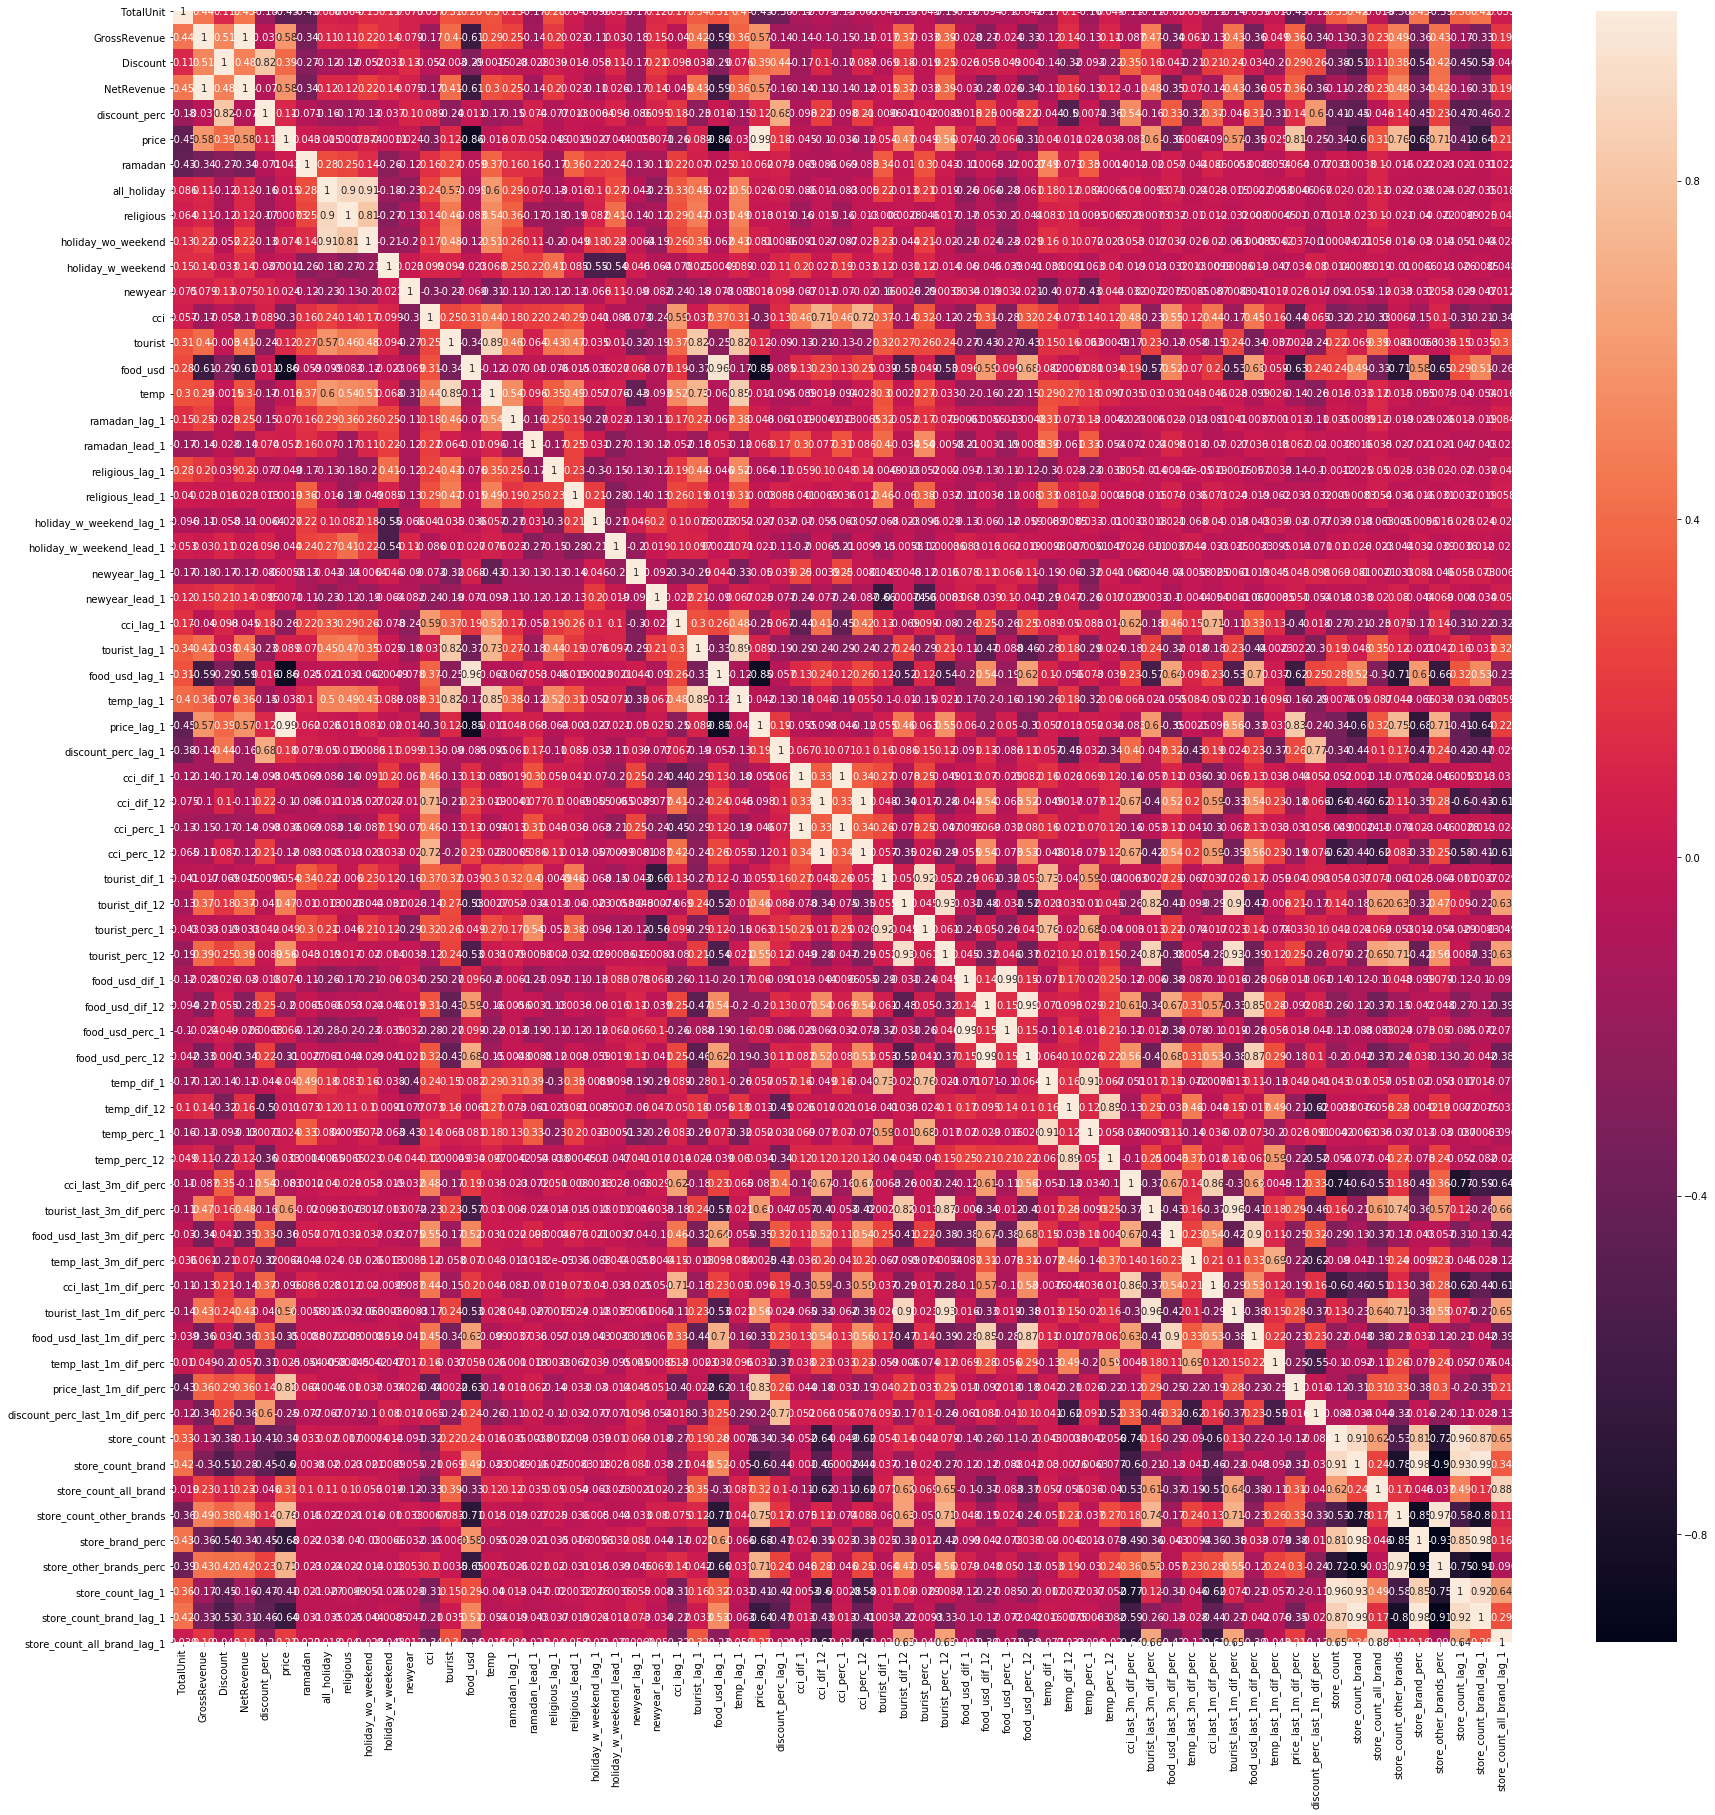

In [0]:
corr_df = unit_df[unit_df.index.year != 2014].corr(method='pearson')
plt.figure(figsize=(30,30))
sns.heatmap(corr_df, annot=True)

# Granger Causality Tests

In [0]:
for column in unit_df.columns[4:]:
  print('--------------------'+' COLUMN: '+column+' --------------------')
  granger_dict = grangercausalitytests(unit_df[(unit_df[column].isna() == False) & (unit_df.index.year != 2014)][['TotalUnit', column]], maxlag=2)
  print()

-------------------- COLUMN: discount_perc --------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4438  , p=0.0143  , df_denom=50, df_num=1
ssr based chi2 test:   chi2=6.8304  , p=0.0090  , df=1
likelihood ratio test: chi2=6.4248  , p=0.0113  , df=1
parameter F test:         F=6.4438  , p=0.0143  , df_denom=50, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0076  , p=0.0247  , df_denom=47, df_num=2
ssr based chi2 test:   chi2=8.8678  , p=0.0119  , df=2
likelihood ratio test: chi2=8.1880  , p=0.0167  , df=2
parameter F test:         F=4.0076  , p=0.0247  , df_denom=47, df_num=2

-------------------- COLUMN: price --------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3228  , p=0.0152  , df_denom=50, df_num=1
ssr based chi2 test:   chi2=6.7022  , p=0.0096  , df=1
likelihood ratio test: chi2=6.3111  , p=0.0120  , df=1
parameter F test:         F=6.3228  , p=0.0152  , d

# Feature Importance

### Sales Lags

In [0]:
for i in range(1,13):
  unit_df['TotalUnit_lag_'+str(i)] = unit_df.TotalUnit.shift(i)

### Moving Averages

In [0]:
for i in [2,3,6,12]:
  unit_df['MA_'+ str(i)] = unit_df.TotalUnit.shift(1).rolling(i).mean()

### Exponential Moving Averages

In [0]:
for i in [2,3,6,12]:
  unit_df['EMA_'+ str(i)] = unit_df.TotalUnit.ewm(span=i,adjust=False).mean().shift(1)

### Last month Change

In [0]:
unit_df['TotalUnit_last_1m_dif'] = unit_df['TotalUnit'].shift(1) - unit_df['TotalUnit'].shift(13)
unit_df['TotalUnit_last_1m_dif_perc'] = (unit_df['TotalUnit'].shift(1) - unit_df['TotalUnit'].shift(13)) / unit_df['TotalUnit'].shift(13)

### Month

In [0]:
unit_df['month'] = unit_df.index.month
month_df = pd.get_dummies(unit_df['month'], drop_first=True)
month_df.columns = ['month_'+str(i) for i in month_df.columns]

In [0]:
unit_df = unit_df.join(month_df)
unit_df.drop('month', axis=1, inplace=True)

In [0]:
print(unit_df.shape)
unit_df.head(3)

(66, 98)


TotalUnit  GrossRevenue  ...  month_11  month_12
MonthBegin                               ...                    
2014-01-31 105,880,798.18 56,892,968.98  ...         0         0
2014-02-28 101,957,734.32 55,649,613.20  ...         0         0
2014-03-31 115,553,118.66 63,055,722.52  ...         0         0

[3 rows x 98 columns]

### Test, Validation and Train Split

In [0]:
train_start,train_end = "2015-01-31","2018-12-31"
test_start,test_end = "2019-01-31","2019-06-30"
unit_df_train = unit_df[train_start:train_end]
unit_df_test = unit_df[test_start:test_end]

print('Number of months in training set:', unit_df_train.index.nunique())
print('Number of months in test set:', unit_df_test.index.nunique())

Number of months in training set: 48
Number of months in test set: 6


### Lasso

In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(unit_df_train.iloc[3:,4:])
y_train = unit_df_train['TotalUnit'].values[3:]

In [0]:
reg = LassoCV(cv=5, random_state=23)
reg.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=23, selection='cyclic',
        tol=0.0001, verbose=False)

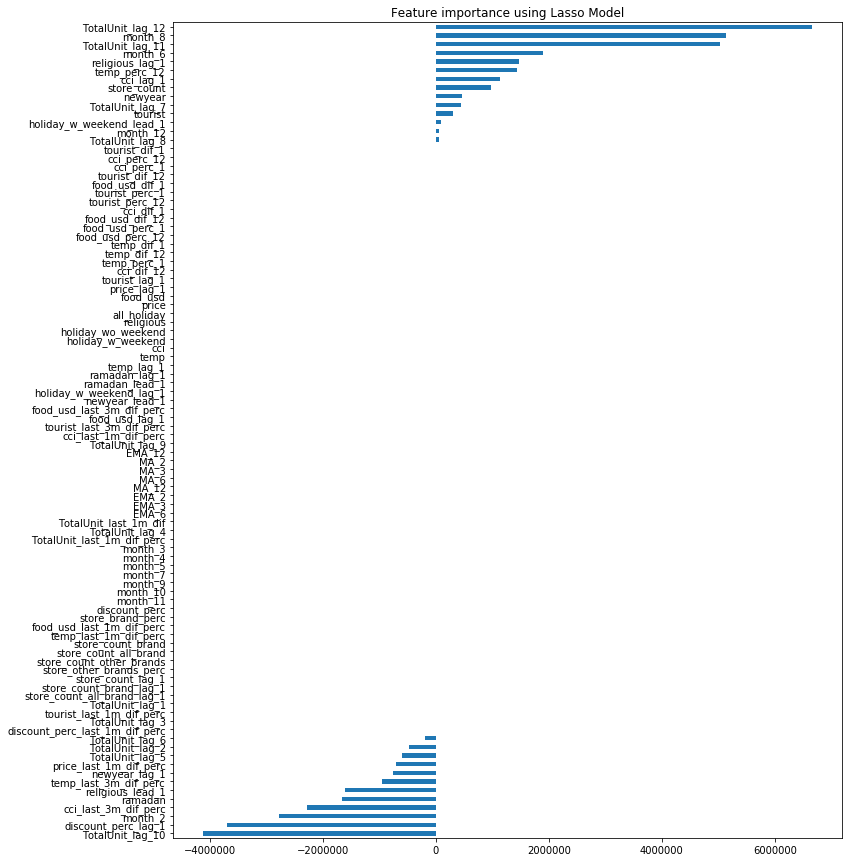

In [0]:
coef = pd.Series(reg.coef_, index = unit_df_train.iloc[3:,4:].columns)
imp_coef = coef.sort_values()
plt.figure(figsize=(12,15))
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")
plt.show()

### Random Forest

In [0]:
grid_param = {
    'max_depth' : [2, 5, 10],
    'n_estimators' : [100, 200, 250]
}
rf = RandomForestRegressor()
reg = GridSearchCV(rf, grid_param, cv=5)
reg.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 5, 10],
      

In [0]:
reg.best_params_

{'max_depth': 5, 'n_estimators': 100}

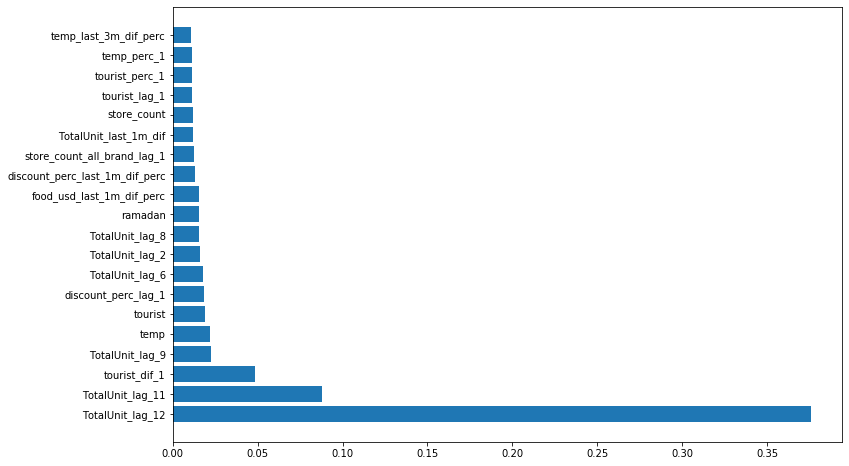

In [0]:
rf = RandomForestRegressor(max_depth = reg.best_params_['max_depth']
                           ,n_estimators = reg.best_params_['n_estimators']
                           ,random_state=23)
rf.fit(X_train, y_train)

importance_df = pd.DataFrame({
    'Feature' : unit_df_train.iloc[3:,4:].columns,
    'Importance' : rf.feature_importances_
}).sort_values('Importance', ascending=False).iloc[:20,:]

plt.figure(figsize = (12,8))
y_pos = np.arange(len(importance_df.Feature))
plt.barh(y_pos, importance_df.Importance)
plt.yticks(y_pos, importance_df.Feature)
plt.show()

### XGBoost

In [0]:
grid_param = {
    'max_depth' : [2, 5, 10, 25],
    'n_estimators' : [100, 200, 250],
    'learning_rate' : [0.01, 0.05, 0.1, 0.5]
}
xgboost = xgb.XGBRegressor(verbosity = 0,random_state=23)
reg = GridSearchCV(xgboost, grid_param, cv=5, verbose=0)
reg.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=23,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [2, 5, 10, 25],
 

In [0]:
reg.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

In [0]:
xgboost = xgb.XGBRegressor(max_depth = reg.best_params_['max_depth']
                           ,n_estimators = reg.best_params_['n_estimators']
                           ,learning_rate = reg.best_params_['learning_rate']
                           ,verbosity = 0
                           ,random_state=23)
xgboost.fit(pd.DataFrame(X_train, columns=unit_df_train.iloc[3:,4:].columns), unit_df_train['TotalUnit'].values[3:], verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=23,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

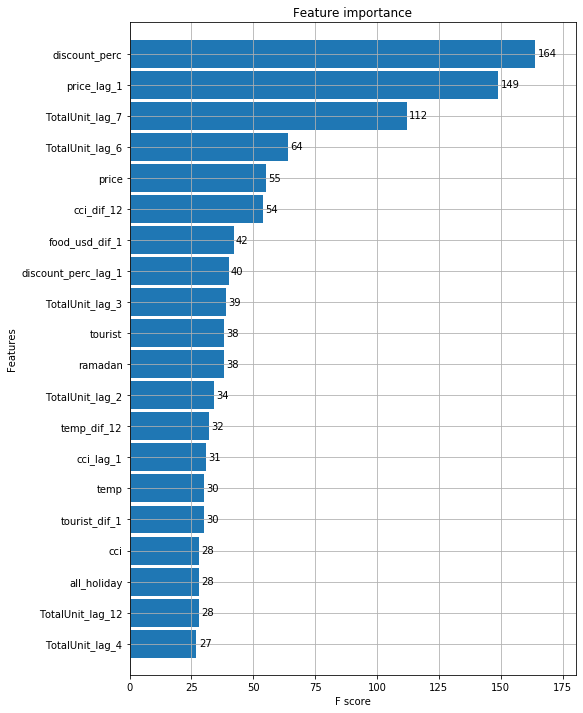

In [0]:
fig, ax = plt.subplots(figsize=(8,12))
xgb.plot_importance(xgboost, height=0.9, ax=ax, max_num_features=20)

# Model Evaluation - Istanbul

## SARIMAX

In [0]:
unit_df.loc['2019-06-30', 'religious_lead_1'] = 0
unit_df.loc['2019-06-30', 'ramadan_lead_1'] = 0

In [0]:
train_start,train_end = "2015-01-31","2018-12-31"
unit_df_train = unit_df[train_start:train_end]
print('Number of months in training & validation (or test) set:', unit_df_train.index.nunique())

Number of months in training & validation (or test) set: 48


In [0]:
#SARIMAX with Rolling Window and Walk Forward Validation
test_period = 6
exog_list = ['ramadan','religious_lead_1', 'temp', 'discount_perc_lag_1','cci_lag_1']

sub_results_list = []
sarima_results_df = pd.DataFrame(columns=["Test Period","Actual","Prediction","MAE","MAPE","ARIMA","SEASONALITY"])

# Walk Forward Validation
for period_number in range(test_period):

    tsa_train = unit_df_train.iloc[period_number:-test_period+period_number,:]
    tsa_test = unit_df_train.iloc[len(tsa_train)+period_number:len(tsa_train)+period_number+1,:]
    print("Train:",min(tsa_train.index),"-",max(tsa_train.index),"-",len(tsa_train.index),"months","   Validate/Test:",min(tsa_test.index),"-",len(tsa_test.index),"months")

    # AUTO ARIMA TO DETERMINE ARIMA & SEASONAL ORDERS
    auto_arima_results = auto_arima(tsa_train["TotalUnit"],
                                    start_p=0, d=None, start_q=0, max_p=3, max_d=3,max_q=3,
                                    start_P=0, D=None, start_Q=0,max_P=3, max_D=3, max_Q=3,
                                    seasonal=True,m=12, scoring='mse',information_criterion="bic",
                                    exog = unit_df_train[exog_list]).get_params()
    auto_arima_order = auto_arima_results["order"]
    auto_arima_seasonal = auto_arima_results["seasonal_order"]

    auto_arima_seasonal = (1,0,0,12) #Manual Override

    #SARIMAX
    model = SARIMAX(tsa_train['TotalUnit'],
                    exog=tsa_train[exog_list],
                    order=auto_arima_order,seasonal_order=auto_arima_seasonal, 
                    enforce_stationarity=False,enforce_invertibility=False).fit()

    test_pred = model.predict(start=tsa_test.index[0], end=tsa_test.index[0],
                               exog= tsa_test[exog_list],dynamic=False, typ='levels')

    if tsa_train['TotalUnit'].min() >= test_pred.values[0]:
      test_pred2 = tsa_train['TotalUnit'].min()
    elif tsa_train['TotalUnit'].max() <= test_pred.values[0]:
      test_pred2 = tsa_train['TotalUnit'].max()
    else:
      test_pred2 = test_pred.values[0]
    
    #test_rmse = rmse(tsa_test["TotalUnit"].loc[test_pred.index],test_pred)
    #test_rmse_perc = test_rmse/float(unit_df_train["TotalUnit"].loc[test_pred.index].values)*100
    test_mae = (abs(float(unit_df_train["TotalUnit"].loc[test_pred.index].values) - test_pred2))
    test_mape = (abs(float(unit_df_train["TotalUnit"].loc[test_pred.index].values) - test_pred2) / float(unit_df_train["TotalUnit"].loc[test_pred.index].values)) * 100

    sub_results_list.append([test_pred.index[0],
                                float(tsa_test["TotalUnit"].loc[test_pred.index].values),
                                      float(test_pred2),
                                      test_mae,test_mape,auto_arima_order,auto_arima_seasonal])
    sub_results_df = pd.DataFrame(data=sub_results_list,columns=["Test Period","Actual","Prediction","MAE","MAPE","ARIMA","SEASONALITY"])

sarima_results_df = pd.concat([sarima_results_df,sub_results_df])

Train: 2015-01-31 00:00:00 - 2018-06-30 00:00:00 - 42 months    Validate/Test: 2018-07-31 00:00:00 - 1 months
Train: 2015-02-28 00:00:00 - 2018-07-31 00:00:00 - 42 months    Validate/Test: 2018-08-31 00:00:00 - 1 months
Train: 2015-03-31 00:00:00 - 2018-08-31 00:00:00 - 42 months    Validate/Test: 2018-09-30 00:00:00 - 1 months
Train: 2015-04-30 00:00:00 - 2018-09-30 00:00:00 - 42 months    Validate/Test: 2018-10-31 00:00:00 - 1 months
Train: 2015-05-31 00:00:00 - 2018-10-31 00:00:00 - 42 months    Validate/Test: 2018-11-30 00:00:00 - 1 months
Train: 2015-06-30 00:00:00 - 2018-11-30 00:00:00 - 42 months    Validate/Test: 2018-12-31 00:00:00 - 1 months


In [0]:
print("\tAverage MAE:","{:,.2f}".format(sarima_results_df["MAE"].mean()),"Average MAPE:","{:,.2f}".format(sarima_results_df["MAPE"].mean()))
sarima_results_df

	Average MAE: 1,738,828.66 Average MAPE: 1.67


Test Period         Actual     Prediction  ...  MAPE      ARIMA    SEASONALITY
0  2018-07-31 116,382,697.26 114,906,609.82  ...  1.27  (0, 1, 1)  (1, 0, 0, 12)
1  2018-08-31 124,894,155.52 127,223,237.65  ...  1.86  (0, 1, 0)  (1, 0, 0, 12)
2  2018-09-30  97,286,022.12 102,414,228.95  ...  5.27  (0, 1, 1)  (1, 0, 0, 12)
3  2018-10-31  97,639,089.90  98,571,156.23  ...  0.95  (0, 1, 0)  (1, 0, 0, 12)
4  2018-11-30 106,243,403.76 106,135,233.14  ...  0.10  (0, 1, 0)  (1, 0, 0, 12)
5  2018-12-31  82,400,667.27  82,860,025.90  ...  0.56  (0, 1, 0)  (1, 0, 0, 12)

[6 rows x 7 columns]

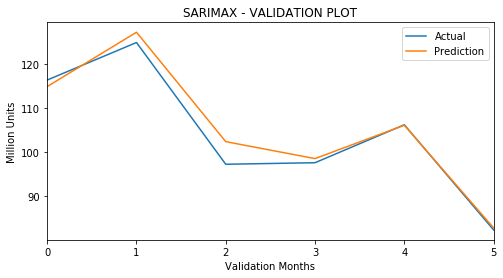

In [0]:
(sarima_results_df[['Actual', 'Prediction']] / 1000000).plot(figsize=(8,4))
plt.title ("SARIMAX - VALIDATION PLOT")
plt.ylabel("Million Units")
plt.xlabel("Validation Months")
plt.show()

## Prophet

In [0]:
unit_df['ds'] = unit_df.index
unit_df['y'] = unit_df.TotalUnit

In [0]:
train_start,train_end = "2015-07-31","2018-12-31"
unit_df_train = unit_df[train_start:train_end]
print('Number of months in training & validation (or test) set:', unit_df_train.index.nunique())

Number of months in training & validation (or test) set: 42


In [0]:
cap_x = round(int(unit_df_train.TotalUnit.max()), 1-len(str(int(unit_df_train.TotalUnit.max()))))
floor_x = round(int(unit_df_train.TotalUnit.min()), 1-len(str(int(unit_df_train.TotalUnit.min()))))
unit_df_train["cap"]=cap_x
unit_df_train["floor"]=floor_x

In [0]:
#Prophet with Rolling Window and Walk Forward Validation
test_period = 6
exog_list = ['ramadan','religious_lead_1', 'temp', 'discount_perc_lag_1','cci_lag_1']
sub_results_list=[]
growth_type="logistic"
seasonality_type="additive"

change_point_list = [0.4]

for change_point in change_point_list:
    sub_results_list = []

    for period_number in range(test_period):

        tsa_train = unit_df_train.iloc[period_number:-test_period+period_number,:]
        tsa_test = unit_df_train.iloc[len(tsa_train)+period_number:len(tsa_train)+period_number+1,:]
        print("Train:",min(tsa_train.index),"-",max(tsa_train.index),"-",len(tsa_train.index),"months","   Validate/Test:",min(tsa_test.index),"-",len(tsa_test.index),"months")

        #Build & Fit Prophet Model
        prop_model = Prophet(growth=growth_type,seasonality_mode = seasonality_type,
                             weekly_seasonality=False,daily_seasonality=False,
                             changepoint_prior_scale=change_point)
        
        prop_model.add_regressor("ramadan",mode="additive")
        prop_model.add_regressor("religious_lead_1",mode="additive")
        prop_model.add_regressor("temp",mode="additive")
        prop_model.add_regressor("discount_perc_lag_1",mode="additive")
        prop_model.add_regressor("cci_lag_1",mode="additive")

        prop_model.fit(tsa_train)

        #Generate Future Table to be Used at Forecasts
        prop_future = prop_model.make_future_dataframe(periods=1, freq='M')
        prop_future = prop_future.merge(unit_df_train[["ds"]+exog_list],
                                        on=["ds"], how='left')
        prop_future["cap"]=cap_x
        prop_future["floor"]=floor_x

        #Forecast
        prop_forecast = prop_model.predict(prop_future)

        if tsa_train['TotalUnit'].min() >= prop_forecast["yhat"].iloc[-1]:
          test_pred2 = tsa_train['TotalUnit'].min()
        elif tsa_train['TotalUnit'].max() <= prop_forecast["yhat"].iloc[-1]:
          test_pred2 = tsa_train['TotalUnit'].max()
        else:
          test_pred2 = prop_forecast["yhat"].iloc[-1]


        #Measurement
        test_mae = abs((tsa_test["y"]) - test_pred2).values[0]
        test_mape = abs((tsa_test["y"]) - test_pred2).values[0] / tsa_test["y"].values[0] * 100

        sub_results_list.append([str(prop_forecast.iloc[-1:,:1].values)[3:13],
                                 float(tsa_test["y"].values),
                                 float(test_pred2),
                                 test_mae,
                                 test_mape,growth_type,change_point,seasonality_type])
prophet_results_df = pd.DataFrame(data=sub_results_list,columns=["Test Period","Actual","Prediction","MAE","MAPE","GROWTH","CHANGEPOINT","SEASONALITY"])

Train: 2015-07-31 00:00:00 - 2018-06-30 00:00:00 - 36 months    Validate/Test: 2018-07-31 00:00:00 - 1 months
Train: 2015-08-31 00:00:00 - 2018-07-31 00:00:00 - 36 months    Validate/Test: 2018-08-31 00:00:00 - 1 months
Train: 2015-09-30 00:00:00 - 2018-08-31 00:00:00 - 36 months    Validate/Test: 2018-09-30 00:00:00 - 1 months
Train: 2015-10-31 00:00:00 - 2018-09-30 00:00:00 - 36 months    Validate/Test: 2018-10-31 00:00:00 - 1 months
Train: 2015-11-30 00:00:00 - 2018-10-31 00:00:00 - 36 months    Validate/Test: 2018-11-30 00:00:00 - 1 months
Train: 2015-12-31 00:00:00 - 2018-11-30 00:00:00 - 36 months    Validate/Test: 2018-12-31 00:00:00 - 1 months


In [0]:
print("\tAverage MAE:","{:,.2f}".format(prophet_results_df["MAE"].mean()),"Average MAPE:","{:,.2f}".format(prophet_results_df["MAPE"].mean()))
prophet_results_df

	Average MAE: 9,458,127.77 Average MAPE: 9.99


Test Period         Actual     Prediction  ...    GROWTH  CHANGEPOINT SEASONALITY
0  2018-07-31 116,382,697.26 123,730,227.93  ...  logistic         0.40    additive
1  2018-08-31 124,894,155.52 132,371,429.39  ...  logistic         0.40    additive
2  2018-09-30  97,286,022.12 110,281,529.80  ...  logistic         0.40    additive
3  2018-10-31  97,639,089.90  98,240,573.62  ...  logistic         0.40    additive
4  2018-11-30 106,243,403.76 108,808,491.13  ...  logistic         0.40    additive
5  2018-12-31  82,400,667.27 108,162,550.61  ...  logistic         0.40    additive

[6 rows x 8 columns]

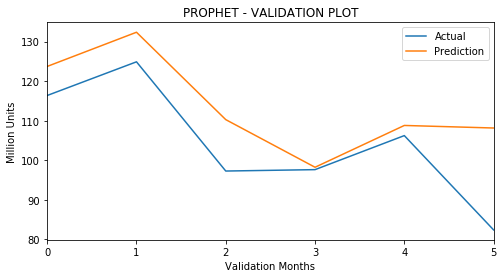

In [0]:
(prophet_results_df[['Actual', 'Prediction']] / 1000000).plot(figsize=(8,4))
plt.title ("PROPHET - VALIDATION PLOT")
plt.ylabel("Million Units")
plt.xlabel("Validation Months")
plt.show()

## XGBoost

In [0]:
selected_columns = [
                    'TotalUnit','ramadan','religious_lead_1', 'temp', 'discount_perc_lag_1','cci_lag_1'
]

unit_df2 = unit_df[selected_columns]

In [0]:
train_start,train_end = "2015-01-31","2018-12-31"
unit_df_train = unit_df2[train_start:train_end]
print('Number of months in training & validation (or test) set:', unit_df_train.index.nunique())

Number of months in training & validation (or test) set: 48


In [0]:
#XGBoost with Rolling Window and Walk Forward Validation
xgb_list = []
test_period = 6

for i in [2, 5]:
  for j in [100, 200, 500]:
    for k in [0.01, 0.05, 0.1]:
      error_list = []
      fit_error_list = []

      for period_number in range(test_period):

          tsa_train = unit_df_train.iloc[period_number:-test_period+period_number,:]
          tsa_test = unit_df_train.iloc[len(tsa_train)+period_number:len(tsa_train)+period_number+1,:]
          X_train, y_train = tsa_train.iloc[:,1:], tsa_train.TotalUnit
          X_test, y_test = tsa_test.iloc[:,1:], tsa_test.TotalUnit

          xgboost = xgb.XGBRegressor(max_depth = i
                                    ,n_estimators = j
                                    ,learning_rate = k
                                    ,verbosity = 0
                                    ,random_state=23)
          xgboost.fit(X_train, y_train, verbose=False)

          y_pred = xgboost.predict(X_test)
          fitted_values = xgboost.predict(X_train)
          error = float(np.abs(y_test-y_pred)/y_test.values)
          mape_fit = (np.abs(y_train-fitted_values)/y_train).mean()
          error_list.append(error)
          fit_error_list.append(mape_fit)

      tpl = ([i, j, k], error_list, np.mean(error_list), np.mean(fit_error_list))
      xgb_list.append(tpl)

xgb_list.sort(key=lambda tup: tup[2])

results_list = []
for period_number in range(test_period):

    tsa_train = unit_df_train.iloc[period_number:-test_period+period_number,:]
    tsa_test = unit_df_train.iloc[len(tsa_train)+period_number:len(tsa_train)+period_number+1,:]
    print("Train:",min(tsa_train.index),"-",max(tsa_train.index),"-",len(tsa_train.index),"months","   Validate/Test:",min(tsa_test.index),"-",len(tsa_test.index),"months")
    X_train, y_train = tsa_train.iloc[:,1:], tsa_train.TotalUnit
    X_test, y_test = tsa_test.iloc[:,1:], tsa_test.TotalUnit

    xgboost = xgb.XGBRegressor(max_depth = xgb_list[0][0][0]
                              ,n_estimators = xgb_list[0][0][1]
                              ,learning_rate = xgb_list[0][0][2]
                              ,verbosity = 0
                              ,random_state=23)
    xgboost.fit(X_train, y_train, verbose=False)
    y_pred = xgboost.predict(X_test)

    if tsa_train['TotalUnit'].min() >= y_pred[0]:
      test_pred2 = tsa_train['TotalUnit'].min()
    elif tsa_train['TotalUnit'].max() <= y_pred[0]:
      test_pred2 = tsa_train['TotalUnit'].max()
    else:
      test_pred2 = y_pred[0]

    #Measurement
    error_mae = float(np.abs(y_test-test_pred2))
    error_mape = float(np.abs(y_test-test_pred2)/y_test.values) * 100

    results_list.append([str(y_test.index[0])[:10],
                              float(tsa_test["TotalUnit"].values),
                              test_pred2,
                              error_mae,
                              error_mape,[xgb_list[0][0][0],xgb_list[0][0][1],xgb_list[0][0][2]]])
xgb_results_df = pd.DataFrame(data=results_list,columns=["Test Period","Actual","Prediction","MAE","MAPE","Parameters"])





Train: 2015-01-31 00:00:00 - 2018-06-30 00:00:00 - 42 months    Validate/Test: 2018-07-31 00:00:00 - 1 months
Train: 2015-02-28 00:00:00 - 2018-07-31 00:00:00 - 42 months    Validate/Test: 2018-08-31 00:00:00 - 1 months
Train: 2015-03-31 00:00:00 - 2018-08-31 00:00:00 - 42 months    Validate/Test: 2018-09-30 00:00:00 - 1 months
Train: 2015-04-30 00:00:00 - 2018-09-30 00:00:00 - 42 months    Validate/Test: 2018-10-31 00:00:00 - 1 months
Train: 2015-05-31 00:00:00 - 2018-10-31 00:00:00 - 42 months    Validate/Test: 2018-11-30 00:00:00 - 1 months
Train: 2015-06-30 00:00:00 - 2018-11-30 00:00:00 - 42 months    Validate/Test: 2018-12-31 00:00:00 - 1 months


In [0]:
print("\tAverage MAE:","{:,.2f}".format(xgb_results_df["MAE"].mean()),"Average MAPE:","{:,.2f}".format(xgb_results_df["MAPE"].mean()))
xgb_results_df

	Average MAE: 8,637,996.29 Average MAPE: 8.11


Test Period         Actual     Prediction           MAE  MAPE      Parameters
0  2018-07-31 116,382,697.26 125,190,688.00  8,807,990.74  7.57  [2, 100, 0.05]
1  2018-08-31 124,894,155.52 111,394,120.00 13,500,035.52 10.81  [2, 100, 0.05]
2  2018-09-30  97,286,022.12 111,941,992.00 14,655,969.88 15.06  [2, 100, 0.05]
3  2018-10-31  97,639,089.90 111,429,488.00 13,790,398.10 14.12  [2, 100, 0.05]
4  2018-11-30 106,243,403.76 107,092,320.00    848,916.24  0.80  [2, 100, 0.05]
5  2018-12-31  82,400,667.27  82,176,000.00    224,667.27  0.27  [2, 100, 0.05]

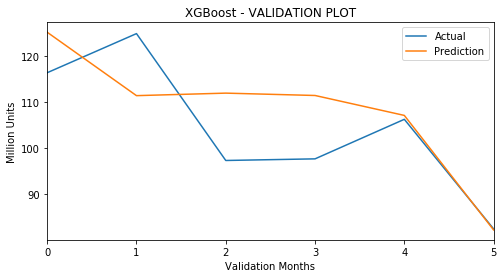

In [0]:
(xgb_results_df[['Actual', 'Prediction']] / 1000000).plot(figsize=(8,4))
plt.title ("XGBoost - VALIDATION PLOT")
plt.ylabel("Million Units")
plt.xlabel("Validation Months")
plt.show()

# Model Evaluation - District Models

In [0]:
train_start,train_end = "2015-01-31","2018-12-31"
train_start_fb,train_end_fb = "2014-07-31","2018-12-31"
test_period = 6
exog_list = ['ramadan','religious_lead_1', 'temp', 'discount_perc_lag_1','cci_lag_1']
growth_type="logistic" #for Prophet
seasonality_type="additive" #for Prophet
change_point_list = [0.4] #for Prophet

In [0]:
#All 3 models with rolling window and Walk Forward Validation for all districts
district_results_list = []
sarima_main_df = pd.DataFrame(columns=["District","Test Period","Actual","Prediction"])
prophet_main_df = pd.DataFrame(columns=["District","Test Period","Actual","Prediction"])
xgb_main_df = pd.DataFrame(columns=["District","Test Period","Actual","Prediction"])
for district in sales_data['District'].unique():
  #Filter sales data
  sales_data_district = sales_data[sales_data['District'] == district]

  #############################
  ####### Add Regressors ######
  #############################
  groupby_dict = {'TotalUnit':'sum',
                  'GrossRevenue':'sum',
                  'Discount':'sum',
                  'NetRevenue':'sum'}

  unit_df_district = sales_data_district.groupby('MonthBegin').agg(groupby_dict)

  unit_df_district['discount_perc'] = unit_df_district['Discount'] / unit_df_district['GrossRevenue']

  unit_df_district = unit_df_district.join(ramazan)
  unit_df_district = unit_df_district.join(holiday3).fillna(0)
  unit_df_district = unit_df_district.join(isttemp)
  unit_df_district = unit_df_district.join(cci)

  lag_column_list = ['cci','discount_perc']
  for column in lag_column_list:
    unit_df_district[column+'_lag_1'] = unit_df_district[column].shift(1)

  lead_column_list = ['religious']
  for column in lead_column_list:
    unit_df_district[column+'_lead_1'] = unit_df_district[column].shift(-1)

  unit_df_district.loc['2019-06-30', 'religious_lead_1'] = 0

  unit_df_district['ds'] = unit_df_district.index
  unit_df_district['y'] = unit_df_district.TotalUnit

  store_counts2 = store_counts[store_counts['District'] == district]
  store_counts2_group = store_counts2.groupby('MonthBegin').store_count.sum()
  unit_df_district = unit_df_district.join(store_counts2_group)

  #############################
  ###### Train Test Split #####
  #############################

  unit_df_train = unit_df_district[train_start:train_end]
  unit_df_train_fb = unit_df_district[train_start_fb:train_end_fb]

  #############################
  ########### SARIMAX #########
  #############################

  sub_results_list = []
  sarima_results_df = pd.DataFrame(columns=["Test Period","Actual","Prediction","MAE","MAPE","ARIMA","SEASONALITY"])

  # Walk Forward Validation
  for period_number in range(test_period):

      tsa_train = unit_df_train.iloc[period_number:-test_period+period_number,:]
      tsa_test = unit_df_train.iloc[len(tsa_train)+period_number:len(tsa_train)+period_number+1,:]
      #print("Train:",min(tsa_train.index),"-",max(tsa_train.index),"-",len(tsa_train.index),"months","   Validate/Test:",min(tsa_test.index),"-",len(tsa_test.index),"months")

      # AUTO ARIMA TO DETERMINE ARIMA & SEASONAL ORDERS
      try:
        auto_arima_results = auto_arima(tsa_train["TotalUnit"],
                                        start_p=0, d=None, start_q=0, max_p=3, max_d=3,max_q=3,
                                        start_P=0, D=None, start_Q=0,max_P=3, max_D=3, max_Q=3,
                                        seasonal=True,m=12, scoring='mse',information_criterion="bic",
                                        exog = unit_df_train[exog_list]).get_params()
        auto_arima_order = auto_arima_results["order"]
        auto_arima_seasonal = auto_arima_results["seasonal_order"]
      except Exception:
        auto_arima_order = (0,1,0)
        print('Auto Arima Error: District:', district, 'Period Number:', period_number)

      auto_arima_seasonal = (1,0,0,12) #Manual Override

      #SARIMAX
      model = SARIMAX(tsa_train['TotalUnit'],
                      exog=tsa_train[exog_list],
                      order=auto_arima_order,seasonal_order=auto_arima_seasonal, 
                      enforce_stationarity=False,enforce_invertibility=False).fit()

      test_pred = model.predict(start=tsa_test.index[0], end=tsa_test.index[0],
                                exog= tsa_test[exog_list],dynamic=False, typ='levels')

      if tsa_train['TotalUnit'].min() >= test_pred.values[0]:
        test_pred2 = tsa_train['TotalUnit'].min()
      elif tsa_train['TotalUnit'].max() <= test_pred.values[0]:
        test_pred2 = tsa_train['TotalUnit'].max()
      else:
        test_pred2 = test_pred.values[0]
      
      #test_rmse = rmse(tsa_test["TotalUnit"].loc[test_pred.index],test_pred)
      #test_rmse_perc = test_rmse/float(unit_df_train["TotalUnit"].loc[test_pred.index].values)*100
      test_mae = (abs(float(unit_df_train["TotalUnit"].loc[test_pred.index].values) - test_pred2))
      test_mape = (abs(float(unit_df_train["TotalUnit"].loc[test_pred.index].values) - test_pred2) / float(unit_df_train["TotalUnit"].loc[test_pred.index].values)) * 100

      sub_results_list.append([district,test_pred.index[0],
                                  float(tsa_test["TotalUnit"].loc[test_pred.index].values),
                                        float(test_pred2),
                                        test_mae,test_mape,auto_arima_order,auto_arima_seasonal])
      sub_results_df = pd.DataFrame(data=sub_results_list,columns=["District","Test Period","Actual","Prediction","MAE","MAPE","ARIMA","SEASONALITY"])


  sarima_results_df = pd.concat([sarima_results_df,sub_results_df])
  sarima_mae = sarima_results_df["MAE"].mean()
  sarima_mape = sarima_results_df["MAPE"].mean()
  sarima_main_df = pd.concat([sarima_main_df,sub_results_df[["District","Test Period","Actual","Prediction"]]])


  #############################
  ########### PROPHET #########
  #############################

  cap_x = round(int(unit_df_train_fb.TotalUnit.max()), 1-len(str(int(unit_df_train_fb.TotalUnit.max()))))
  floor_x = round(int(unit_df_train_fb.TotalUnit.min()), 1-len(str(int(unit_df_train_fb.TotalUnit.min()))))
  unit_df_train_fb["cap"]=cap_x
  unit_df_train_fb["floor"]=floor_x

  sub_results_list=[]
  for change_point in change_point_list:
      sub_results_list = []

      for period_number in range(test_period):

          tsa_train = unit_df_train_fb.iloc[period_number:-test_period+period_number,:]
          tsa_test = unit_df_train_fb.iloc[len(tsa_train)+period_number:len(tsa_train)+period_number+1,:]
          #print("Train:",min(tsa_train.index),"-",max(tsa_train.index),"-",len(tsa_train.index),"months","   Validate/Test:",min(tsa_test.index),"-",len(tsa_test.index),"months")

          #Build & Fit Prophet Model
          prop_model = Prophet(growth=growth_type,seasonality_mode = seasonality_type,
                              weekly_seasonality=False,daily_seasonality=False,
                              changepoint_prior_scale=change_point)
          
          prop_model.add_regressor("ramadan",mode="additive")
          prop_model.add_regressor("religious_lead_1",mode="additive")
          prop_model.add_regressor("temp",mode="additive")
          prop_model.add_regressor("discount_perc_lag_1",mode="additive")
          prop_model.add_regressor("cci_lag_1",mode="additive")

          prop_model.fit(tsa_train)

          #Generate Future Table to be Used at Forecasts
          prop_future = prop_model.make_future_dataframe(periods=1, freq='M')
          prop_future = prop_future.merge(unit_df_train_fb[["ds"]+exog_list],
                                          on=["ds"], how='left')
          prop_future["cap"]=cap_x
          prop_future["floor"]=floor_x

          #Forecast
          prop_forecast = prop_model.predict(prop_future)

          if tsa_train['TotalUnit'].min() >= prop_forecast["yhat"].iloc[-1]:
            test_pred2 = tsa_train['TotalUnit'].min()
          elif tsa_train['TotalUnit'].max() <= prop_forecast["yhat"].iloc[-1]:
            test_pred2 = tsa_train['TotalUnit'].max()
          else:
            test_pred2 = prop_forecast["yhat"].iloc[-1]


          #Measurement
          test_mae = abs((tsa_test["y"]) - test_pred2).values[0]
          test_mape = abs((tsa_test["y"]) - test_pred2).values[0] / tsa_test["y"].values[0] * 100

          sub_results_list.append([district,str(prop_forecast.iloc[-1:,:1].values)[3:13],
                                  float(tsa_test["y"].values),
                                  float(test_pred2),
                                  test_mae,
                                  test_mape,growth_type,change_point,seasonality_type])
  prophet_results_df = pd.DataFrame(data=sub_results_list,columns=["District","Test Period","Actual","Prediction","MAE","MAPE","GROWTH","CHANGEPOINT","SEASONALITY"])
  prophet_mae = prophet_results_df["MAE"].mean()
  prophet_mape = prophet_results_df["MAPE"].mean()
  prophet_main_df = pd.concat([prophet_main_df,prophet_results_df[["District","Test Period","Actual","Prediction"]]])


  #############################
  ########### XGBOOST #########
  #############################

  unit_df_train = unit_df_train[['TotalUnit']+exog_list]
  xgb_list = []
  for i in [2, 5]:
    for j in [100, 200, 500]:
      for k in [0.01, 0.05, 0.1]:
        error_list = []
        fit_error_list = []

        for period_number in range(test_period):

            tsa_train = unit_df_train.iloc[period_number:-test_period+period_number,:]
            tsa_test = unit_df_train.iloc[len(tsa_train)+period_number:len(tsa_train)+period_number+1,:]
            X_train, y_train = tsa_train.iloc[:,1:], tsa_train.TotalUnit
            X_test, y_test = tsa_test.iloc[:,1:], tsa_test.TotalUnit

            xgboost = xgb.XGBRegressor(max_depth = i
                                      ,n_estimators = j
                                      ,learning_rate = k
                                      ,verbosity = 0
                                      ,random_state=23)
            xgboost.fit(X_train, y_train, verbose=False)

            y_pred = xgboost.predict(X_test)
            fitted_values = xgboost.predict(X_train)
            error = float(np.abs(y_test-y_pred)/y_test.values)
            mape_fit = (np.abs(y_train-fitted_values)/y_train).mean()
            error_list.append(error)
            fit_error_list.append(mape_fit)

        tpl = ([i, j, k], error_list, np.mean(error_list), np.mean(fit_error_list))
        xgb_list.append(tpl)

  xgb_list.sort(key=lambda tup: tup[2])

  results_list = []
  for period_number in range(test_period):

      tsa_train = unit_df_train.iloc[period_number:-test_period+period_number,:]
      tsa_test = unit_df_train.iloc[len(tsa_train)+period_number:len(tsa_train)+period_number+1,:]
      #print("Train:",min(tsa_train.index),"-",max(tsa_train.index),"-",len(tsa_train.index),"months","   Validate/Test:",min(tsa_test.index),"-",len(tsa_test.index),"months")
      X_train, y_train = tsa_train.iloc[:,1:], tsa_train.TotalUnit
      X_test, y_test = tsa_test.iloc[:,1:], tsa_test.TotalUnit

      xgboost = xgb.XGBRegressor(max_depth = xgb_list[0][0][0]
                                ,n_estimators = xgb_list[0][0][1]
                                ,learning_rate = xgb_list[0][0][2]
                                ,verbosity = 0
                                ,random_state=23)
      xgboost.fit(X_train, y_train, verbose=False)
      y_pred = xgboost.predict(X_test)

      if tsa_train['TotalUnit'].min() >= y_pred[0]:
        test_pred2 = tsa_train['TotalUnit'].min()
      elif tsa_train['TotalUnit'].max() <= y_pred[0]:
        test_pred2 = tsa_train['TotalUnit'].max()
      else:
        test_pred2 = y_pred[0]

      #Measurement
      error_mae = float(np.abs(y_test-test_pred2))
      error_mape = float(np.abs(y_test-test_pred2)/y_test.values) * 100

      results_list.append([district,str(y_test.index[0])[:10],
                                float(tsa_test["TotalUnit"].values),
                                test_pred2,
                                error_mae,
                                error_mape,[xgb_list[0][0][0],xgb_list[0][0][1],xgb_list[0][0][2]]])
  xgb_results_df = pd.DataFrame(data=results_list,columns=["District","Test Period","Actual","Prediction","MAE","MAPE","Parameters"])
  xgb_mae = xgb_results_df["MAE"].mean()
  xgb_mape = xgb_results_df["MAPE"].mean()
  xgb_main_df = pd.concat([xgb_main_df,xgb_results_df[["District","Test Period","Actual","Prediction"]]])



  district_results_list.append([district, sarima_mae, sarima_mape, prophet_mae, prophet_mape, xgb_mae, xgb_mape])

  print(district, '-> finished')

district_results_df = pd.DataFrame(district_results_list, columns=['district', 'sarima_mae', 'sarima_mape', 'prophet_mae', 'prophet_mape', 'xgb_mae', 'xgb_mape'])

Arnavutköy -> finished
Çatalca -> finished
Auto Arima Error: District: Esenyurt Period Number: 1
Auto Arima Error: District: Esenyurt Period Number: 2
Esenyurt -> finished
Adalar -> finished
Auto Arima Error: District: Silivri Period Number: 0
Auto Arima Error: District: Silivri Period Number: 1
Auto Arima Error: District: Silivri Period Number: 2
Auto Arima Error: District: Silivri Period Number: 3
Auto Arima Error: District: Silivri Period Number: 4
Auto Arima Error: District: Silivri Period Number: 5
Silivri -> finished
Büyükçekmece -> finished
Başakşehir -> finished
Beylikdüzü -> finished
Kadıköy -> finished
Auto Arima Error: District: Gaziosmanpaşa Period Number: 0
Auto Arima Error: District: Gaziosmanpaşa Period Number: 1
Auto Arima Error: District: Gaziosmanpaşa Period Number: 2
Gaziosmanpaşa -> finished
Eyüp -> finished
Ümraniye -> finished
Şişli -> finished
Küçükçekmece -> finished
Auto Arima Error: District: Sarıyer Period Number: 0
Auto Arima Error: District: Sarıyer Period 

In [0]:
print('Sarima Avg:', district_results_df.sarima_mape.mean(), 'Prophet Avg:', district_results_df.prophet_mape.mean(), 'XGBoost Avg:', district_results_df.xgb_mape.mean())
district_results_df.sort_values('sarima_mape')

Sarima Avg: 13.88506449186096 Prophet Avg: 17.148751110151764 XGBoost Avg: 14.54857549390744


district  sarima_mae  sarima_mape  ...  prophet_mape      xgb_mae  xgb_mape
9   Gaziosmanpaşa  196,312.22         5.27  ...         10.77   308,419.04      8.37
16      Kağıthane  177,748.09         5.28  ...         13.99   302,174.43      9.15
12          Şişli  233,160.26         5.65  ...          7.63   301,249.74      7.11
26         Pendik  160,473.08         5.81  ...         13.73   218,188.07      7.55
28       Güngören   96,416.88         6.47  ...         11.98   164,375.97     10.30
8         Kadıköy  866,608.24         7.89  ...          5.48 1,034,582.72      9.13
24        Esenler  177,718.30         8.41  ...          9.27   188,527.14      8.96
14        Sarıyer  251,003.64         8.41  ...          8.44   359,576.08     11.58
21   Bahçelievler  283,801.25         8.64  ...          5.78   471,169.39     12.66
18          Fatih  605,129.46         9.11  ...         13.08   571,403.29      8.67
22     Bayrampaşa  260,862.16         9.44  ...          9.97   477,161.10     16.63
17       Beşiktaş  415,266.47        10.01  ...          7.70   461,337.11     11.22
20     Sultangazi  189,315.46        10.30  ...         17.89   228,027.69     13.08
35          Tuzla  142,982.73        10.67  ...         11.49   190,886.05     14.67
15        Beyoğlu  796,101.16        10.78  ...         15.65   476,946.26      6.47
10           Eyüp  287,339.97        11.23  ...         12.71   275,432.00      9.98
6      Başakşehir  143,425.39        11.24  ...         14.88   187,062.62     15.59
7      Beylikdüzü  183,656.02        11.31  ...         19.91   162,723.91      9.81
31       Bakırköy  371,599.12        12.23  ...         17.14   451,235.21     13.91
27        Maltepe  343,354.37        12.73  ...         19.55   356,299.20     13.78
33       Çekmeköy  125,893.89        13.03  ...         13.52   116,052.82     11.18
36    Sultanbeyli   61,968.08        13.78  ...         14.81    52,301.35     10.71
30       Ataşehir  379,321.29        13.90  ...         16.70   249,802.67      9.76
25         Kartal  450,992.81        14.38  ...          9.99   272,602.13      7.88
19       Bağcılar  330,727.25        14.47  ...         14.74   368,249.27     15.12
32     Sancaktepe  168,374.05        15.77  ...         16.99   168,422.71     15.42
11       Ümraniye  441,256.03        16.09  ...         19.33   763,298.51     22.26
23    Zeytinburnu  327,113.56        16.15  ...         13.38   290,474.92     13.08
13   Küçükçekmece  548,334.97        16.50  ...          6.74   553,287.17     16.62
1         Çatalca  106,679.98        17.15  ...         37.42   315,745.50     32.15
29        Üsküdar  327,351.88        17.82  ...         20.20   310,308.16     15.52
0      Arnavutköy  145,415.29        17.87  ...         30.40   273,985.33     25.96
2        Esenyurt  467,292.25        19.98  ...         23.06   660,220.89     25.05
4         Silivri  267,617.37        23.21  ...         47.48   527,246.16     30.02
5    Büyükçekmece  310,876.25        23.83  ...         22.83   336,219.37     20.18
34         Beykoz  473,021.62        33.33  ...         20.17   248,544.45     18.71
3          Adalar  130,613.80        45.60  ...         59.73   148,261.26     30.07

[37 rows x 7 columns]

# Final Model Test with SARIMAX

In [0]:
train_start,train_end = "2015-07-31","2019-06-30"
unit_df_train = unit_df[train_start:train_end]
print('Number of months in training & validation (or test) set:', unit_df_train.index.nunique())

Number of months in training & validation (or test) set: 48


### Istanbul Model

In [0]:
test_period = 6
exog_list = ['ramadan','religious_lead_1', 'temp', 'discount_perc_lag_1','cci_lag_1']

sub_results_list = []
results_df = pd.DataFrame(columns=["Test Period","Actual","Prediction","MAE","MAPE","ARIMA","SEASONALITY"])

# Walk Forward Validation
for period_number in range(test_period):

    tsa_train = unit_df_train.iloc[period_number:-test_period+period_number,:]
    tsa_test = unit_df_train.iloc[len(tsa_train)+period_number:len(tsa_train)+period_number+1,:]
    print("Train:",min(tsa_train.index),"-",max(tsa_train.index),"-",len(tsa_train.index),"months","   Validate/Test:",min(tsa_test.index),"-",len(tsa_test.index),"months")

    # AUTO ARIMA TO DETERMINE ARIMA & SEASONAL ORDERS
    auto_arima_results = auto_arima(tsa_train["TotalUnit"],
                                    start_p=0, d=None, start_q=0, max_p=3, max_d=3,max_q=3,
                                    start_P=0, D=None, start_Q=0,max_P=3, max_D=3, max_Q=3,
                                    seasonal=True,m=12, scoring='mse',information_criterion="bic",
                                    exog = tsa_train[exog_list]).get_params()
    auto_arima_order = auto_arima_results["order"]
    auto_arima_seasonal = auto_arima_results["seasonal_order"]

    auto_arima_seasonal = (1,0,0,12) #Manual Override

    #SARIMAX
    model = SARIMAX(tsa_train['TotalUnit'],
                    exog=tsa_train[exog_list],
                    order=auto_arima_order,seasonal_order=auto_arima_seasonal, 
                    enforce_stationarity=False,enforce_invertibility=False).fit()

    test_pred = model.predict(start=tsa_test.index[0], end=tsa_test.index[0],
                               exog= tsa_test[exog_list],dynamic=False, typ='levels')

    if tsa_train['TotalUnit'].min() >= test_pred.values[0]:
      test_pred2 = tsa_train['TotalUnit'].min()
    elif tsa_train['TotalUnit'].max() <= test_pred.values[0]:
      test_pred2 = tsa_train['TotalUnit'].max()
    else:
      test_pred2 = test_pred.values[0]
    
    #test_rmse = rmse(tsa_test["TotalUnit"].loc[test_pred.index],test_pred)
    #test_rmse_perc = test_rmse/float(unit_df_train["TotalUnit"].loc[test_pred.index].values)*100
    test_mae = (abs(float(unit_df_train["TotalUnit"].loc[test_pred.index].values) - test_pred2))
    test_mape = (abs(float(unit_df_train["TotalUnit"].loc[test_pred.index].values) - test_pred2) / float(unit_df_train["TotalUnit"].loc[test_pred.index].values)) * 100

    sub_results_list.append([test_pred.index[0],
                                float(tsa_test["TotalUnit"].loc[test_pred.index].values),
                                      float(test_pred2),
                                      test_mae,test_mape,auto_arima_order,auto_arima_seasonal])
    sub_results_df = pd.DataFrame(data=sub_results_list,columns=["Test Period","Actual","Prediction","MAE","MAPE","ARIMA","SEASONALITY"])
    

results_df = pd.concat([results_df,sub_results_df])

Train: 2015-07-31 00:00:00 - 2018-12-31 00:00:00 - 42 months    Validate/Test: 2019-01-31 00:00:00 - 1 months
Train: 2015-08-31 00:00:00 - 2019-01-31 00:00:00 - 42 months    Validate/Test: 2019-02-28 00:00:00 - 1 months
Train: 2015-09-30 00:00:00 - 2019-02-28 00:00:00 - 42 months    Validate/Test: 2019-03-31 00:00:00 - 1 months
Train: 2015-10-31 00:00:00 - 2019-03-31 00:00:00 - 42 months    Validate/Test: 2019-04-30 00:00:00 - 1 months
Train: 2015-11-30 00:00:00 - 2019-04-30 00:00:00 - 42 months    Validate/Test: 2019-05-31 00:00:00 - 1 months
Train: 2015-12-31 00:00:00 - 2019-05-31 00:00:00 - 42 months    Validate/Test: 2019-06-30 00:00:00 - 1 months


In [0]:
print("\tAverage MAE:","{:,.2f}".format(results_df["MAE"].mean()),"Average MAPE:","{:,.2f}".format(results_df["MAPE"].mean()))
results_df

	Average MAE: 4,556,297.06 Average MAPE: 6.31


Test Period         Actual     Prediction  ...  MAPE      ARIMA    SEASONALITY
0  2019-01-31  68,781,705.38  69,785,285.97  ...  1.46  (0, 0, 1)  (1, 0, 0, 12)
1  2019-02-28  62,089,346.38  60,087,813.15  ...  3.22  (0, 0, 1)  (1, 0, 0, 12)
2  2019-03-31  92,045,246.24  85,305,750.52  ...  7.32  (0, 0, 0)  (1, 0, 0, 12)
3  2019-04-30  72,081,646.83  85,832,502.05  ... 19.08  (0, 0, 0)  (1, 0, 0, 12)
4  2019-05-31  54,286,976.39  57,812,310.34  ...  6.49  (0, 0, 0)  (1, 0, 0, 12)
5  2019-06-30 106,870,637.91 107,187,621.54  ...  0.30  (0, 0, 0)  (1, 0, 0, 12)

[6 rows x 7 columns]

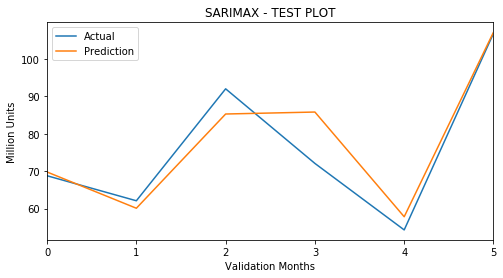

In [0]:
(results_df[['Actual', 'Prediction']] / 1000000).plot(figsize=(8,4))
plt.title ("SARIMAX - TEST PLOT")
plt.ylabel("Million Units")
plt.xlabel("Validation Months")
plt.show()

### District Models

In [0]:
train_start,train_end = "2015-07-31","2019-06-30"
test_period = 6
exog_list = ['ramadan','religious_lead_1', 'temp', 'discount_perc_lag_1','cci_lag_1']

In [0]:
sarima_main_df = pd.DataFrame(columns=["District","Test Period","Actual","Prediction"])
district_results_list = []
for district in sales_data['District'].unique():
  #Filter sales data
  sales_data_district = sales_data[sales_data['District'] == district]

  #############################
  ####### Add Regressors ######
  #############################
  groupby_dict = {'TotalUnit':'sum',
                  'GrossRevenue':'sum',
                  'Discount':'sum',
                  'NetRevenue':'sum'}

  unit_df_district = sales_data_district.groupby('MonthBegin').agg(groupby_dict)

  unit_df_district['discount_perc'] = unit_df_district['Discount'] / unit_df_district['GrossRevenue']

  unit_df_district = unit_df_district.join(ramazan)
  unit_df_district = unit_df_district.join(holiday3).fillna(0)
  unit_df_district = unit_df_district.join(isttemp)
  unit_df_district = unit_df_district.join(cci)

  lag_column_list = ['cci','discount_perc']
  for column in lag_column_list:
    unit_df_district[column+'_lag_1'] = unit_df_district[column].shift(1)

  lead_column_list = ['religious']
  for column in lead_column_list:
    unit_df_district[column+'_lead_1'] = unit_df_district[column].shift(-1)

  unit_df_district.loc['2019-06-30', 'religious_lead_1'] = 0

  unit_df_district['ds'] = unit_df_district.index
  unit_df_district['y'] = unit_df_district.TotalUnit
  

  #############################
  ###### Train Test Split #####
  #############################

  unit_df_train = unit_df_district[train_start:train_end]

  #############################
  ########### SARIMAX #########
  #############################

  sub_results_list = []
  sarima_results_df = pd.DataFrame(columns=["Test Period","Actual","Prediction","MAE","MAPE","ARIMA","SEASONALITY"])

  # Walk Forward Validation
  for period_number in range(test_period):

      tsa_train = unit_df_train.iloc[period_number:-test_period+period_number,:]
      tsa_test = unit_df_train.iloc[len(tsa_train)+period_number:len(tsa_train)+period_number+1,:]
      #print("Train:",min(tsa_train.index),"-",max(tsa_train.index),"-",len(tsa_train.index),"months","   Validate/Test:",min(tsa_test.index),"-",len(tsa_test.index),"months")

      # AUTO ARIMA TO DETERMINE ARIMA & SEASONAL ORDERS
      try:
        auto_arima_results = auto_arima(tsa_train["TotalUnit"],
                                        start_p=0, d=None, start_q=0, max_p=3, max_d=3,max_q=3,
                                        start_P=0, D=None, start_Q=0,max_P=3, max_D=3, max_Q=3,
                                        seasonal=True,m=12, scoring='mse',information_criterion="bic",
                                        exog = unit_df_train[exog_list]).get_params()
        auto_arima_order = auto_arima_results["order"]
        auto_arima_seasonal = auto_arima_results["seasonal_order"]
      except Exception:
        auto_arima_order = (0,0,0)
        print('Auto Arima Error: District:', district, 'Period Number:', period_number)

      auto_arima_seasonal = (1,0,0,12) #Manual Override

      #SARIMAX
      model = SARIMAX(tsa_train['TotalUnit'],
                      exog=tsa_train[exog_list],
                      order=auto_arima_order,seasonal_order=auto_arima_seasonal, 
                      enforce_stationarity=False,enforce_invertibility=False).fit()

      test_pred = model.predict(start=tsa_test.index[0], end=tsa_test.index[0],
                                exog= tsa_test[exog_list],dynamic=False, typ='levels')
      
      if tsa_train['TotalUnit'].min() >= test_pred.values[0]:
        test_pred2 = tsa_train['TotalUnit'].min()
      elif tsa_train['TotalUnit'].max() <= test_pred.values[0]:
        test_pred2 = tsa_train['TotalUnit'].max()
      else:
        test_pred2 = test_pred.values[0]
      
      #test_rmse = rmse(tsa_test["TotalUnit"].loc[test_pred.index],test_pred)
      #test_rmse_perc = test_rmse/float(unit_df_train["TotalUnit"].loc[test_pred.index].values)*100
      test_mae = (abs(float(unit_df_train["TotalUnit"].loc[test_pred.index].values) - test_pred2))
      test_mape = (abs(float(unit_df_train["TotalUnit"].loc[test_pred.index].values) - test_pred2) / float(unit_df_train["TotalUnit"].loc[test_pred.index].values)) * 100

      sub_results_list.append([district,test_pred.index[0],
                                  float(tsa_test["TotalUnit"].loc[test_pred.index].values),
                                        float(test_pred2),
                                        test_mae,test_mape,auto_arima_order,auto_arima_seasonal])
      sub_results_df = pd.DataFrame(data=sub_results_list,columns=["District","Test Period","Actual","Prediction","MAE","MAPE","ARIMA","SEASONALITY"])


  sarima_results_df = pd.concat([sarima_results_df,sub_results_df])
  sarima_mae = sarima_results_df["MAE"].mean()
  sarima_mape = sarima_results_df["MAPE"].mean()
  sarima_main_df = pd.concat([sarima_main_df,sub_results_df[["District","Test Period","Actual","Prediction"]]])



  district_results_list.append([district, sarima_mae, sarima_mape])

  print(district, '-> finished')  

district_results_df = pd.DataFrame(district_results_list, columns=['district', 'sarima_mae', 'sarima_mape'])

Arnavutköy -> finished
Çatalca -> finished
Esenyurt -> finished
Adalar -> finished
Auto Arima Error: District: Silivri Period Number: 0
Auto Arima Error: District: Silivri Period Number: 2
Auto Arima Error: District: Silivri Period Number: 3
Silivri -> finished
Büyükçekmece -> finished
Başakşehir -> finished
Beylikdüzü -> finished
Kadıköy -> finished
Auto Arima Error: District: Gaziosmanpaşa Period Number: 4
Auto Arima Error: District: Gaziosmanpaşa Period Number: 5
Gaziosmanpaşa -> finished
Eyüp -> finished
Auto Arima Error: District: Ümraniye Period Number: 3
Ümraniye -> finished
Şişli -> finished
Küçükçekmece -> finished
Auto Arima Error: District: Sarıyer Period Number: 0
Auto Arima Error: District: Sarıyer Period Number: 3
Auto Arima Error: District: Sarıyer Period Number: 4
Sarıyer -> finished
Beyoğlu -> finished
Kağıthane -> finished
Beşiktaş -> finished
Auto Arima Error: District: Fatih Period Number: 0
Auto Arima Error: District: Fatih Period Number: 3
Auto Arima Error: Distri

In [0]:
district_results_df2 = district_results_df.merge(sales_data.groupby('District').TotalUnit.sum() / sales_data.TotalUnit.sum(), left_on='district', right_on='District')
print('Sarima MAPE Avg:', sum(district_results_df2.sarima_mape * district_results_df2.TotalUnit))
district_results_df.sort_values('sarima_mape')

Sarima MAPE Avg: 16.0257664948977


district   sarima_mae  sarima_mape
23    Zeytinburnu    94,442.09         7.03
13   Küçükçekmece   178,726.25         7.56
14        Sarıyer   181,048.47         8.02
25         Kartal   171,792.33         8.70
6      Başakşehir    61,301.59         8.94
22     Bayrampaşa   181,241.67         9.70
18          Fatih   463,246.08         9.71
17       Beşiktaş   367,125.25         9.84
26         Pendik   201,088.93        10.17
5    Büyükçekmece   116,468.07        10.27
8         Kadıköy   869,790.56        10.45
29        Üsküdar   165,309.18        10.75
11       Ümraniye   202,396.66        10.75
30       Ataşehir   271,990.46        11.96
7      Beylikdüzü   132,960.21        12.77
2        Esenyurt   233,329.64        14.12
9   Gaziosmanpaşa   350,746.58        14.33
35          Tuzla   149,921.41        14.36
19       Bağcılar   258,998.33        14.70
27        Maltepe   301,870.40        15.18
12          Şişli   549,006.37        16.84
24        Esenler   200,068.19        18.16
10           Eyüp   331,458.98        19.77
34         Beykoz   216,959.37        21.25
21   Bahçelievler   458,841.80        21.59
15        Beyoğlu 1,301,504.98        22.65
4         Silivri   170,512.51        23.31
20     Sultangazi   308,703.50        23.83
28       Güngören   235,958.64        24.17
36    Sultanbeyli    68,647.84        25.58
33       Çekmeköy   166,270.81        27.79
32     Sancaktepe   230,973.37        29.35
16      Kağıthane   570,191.65        29.71
31       Bakırköy   604,546.38        31.81
1         Çatalca   128,887.68        32.56
3          Adalar    36,600.99        32.73
0      Arnavutköy   292,363.51        52.66